## Prism Data

In [278]:
!pip install lightgbm
!pip install catboost
!pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [432]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import plotly.express as px
import time
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

In [280]:
consdf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-consDF.pqt') #shows delinquents and credit score
acctdf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-acctDF.pqt') #displays accounts and balances
trxndf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-trxnDF.pqt') #each transaction with category number and amounts
cat_map = pd.read_csv('/uss/hdsi-prismdata/q2-ucsd-cat-map.csv') #mapping for category numbers

In [281]:
cat_map

,category_id,category
0,0,SELF_TRANSFER
1,1,EXTERNAL_TRANSFER
2,2,DEPOSIT
3,3,PAYCHECK
4,4,MISCELLANEOUS
5,5,PAYCHECK_PLACEHOLDER
6,6,REFUND
7,7,INVESTMENT_INCOME
8,8,OTHER_BENEFITS
9,9,UNEMPLOYMENT_BENEFITS


In [282]:
consdf.dropna()['prism_consumer_id'].nunique(),acctdf['prism_consumer_id'].nunique(),trxndf['prism_consumer_id'].nunique()

(12000, 13009, 14492)

In [283]:
total = set(consdf.dropna()['prism_consumer_id'].unique()) & set(acctdf['prism_consumer_id'].unique()) & set(trxndf['prism_consumer_id'].unique())
len(total)

10122

### Week 3

In [284]:
initial_df = (
    acctdf
    .merge(consdf, on='prism_consumer_id', how='inner')
    .groupby(['prism_consumer_id'])
    .agg(
        balance=('balance', 'sum'),
        balance_date=('balance_date', 'max')
    )
    .reset_index()
).merge(trxndf,on='prism_consumer_id')
initial_df.head()

,prism_consumer_id,balance,balance_date,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,0,320.37,2021-08-31,136696,4,0.09,CREDIT,2021-03-19
1,0,320.37,2021-08-31,136697,4,0.05,CREDIT,2021-04-16
2,0,320.37,2021-08-31,136698,4,0.06,CREDIT,2021-05-21
3,0,320.37,2021-08-31,136699,4,0.04,CREDIT,2021-06-18
4,0,320.37,2021-08-31,136700,4,0.02,CREDIT,2021-07-16


In [285]:
mapping = dict(zip(cat_map["category_id"], cat_map["category"]))
initial_df["category"] = initial_df["category"].replace(mapping)
monthly_summary=initial_df.copy()
monthly_summary['amount'] = np.where(initial_df['credit_or_debit'] == 'DEBIT', -initial_df['amount'],initial_df['amount'])
monthly_summary['posted_date'] = pd.to_datetime(monthly_summary['posted_date'])
monthly_summary = (
    monthly_summary
    .groupby(['prism_consumer_id', monthly_summary['posted_date'].dt.to_period('M')])
    .agg(
        starting_balance=('balance', 'first'),
        monthly_total=('balance', 'sum'),
        trxndf_count = ('balance', 'count')
    )
    .reset_index()
)
monthly_summary['posted_date'] = monthly_summary['posted_date'].dt.to_timestamp()

In [286]:
monthly_summary = monthly_summary.merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()

In [287]:
# ensure date type
monthly_summary["posted_date"] = pd.to_datetime(monthly_summary["posted_date"])

# sort properly
monthly_summary = monthly_summary.sort_values(["prism_consumer_id", "posted_date"])

# calculate running balance
monthly_summary["monthly_balance"] = (
    monthly_summary["starting_balance"]
    + monthly_summary.groupby("prism_consumer_id")["monthly_total"].cumsum()
)
monthly_summary

,prism_consumer_id,posted_date,starting_balance,monthly_total,trxndf_count,DQ_TARGET,monthly_balance
0,0,2021-03-01,320.37,10572.21,33,0.0,10892.58
1,0,2021-04-01,320.37,22105.53,69,0.0,32998.11
2,0,2021-05-01,320.37,11853.69,37,0.0,44851.80
3,0,2021-06-01,320.37,27231.45,85,0.0,72083.25
4,0,2021-07-01,320.37,23707.38,74,0.0,95790.63
...,...,...,...,...,...,...,...
74439,999,2020-11-01,2236.37,140891.31,63,0.0,237055.22
74440,999,2020-12-01,2236.37,351110.09,157,0.0,588165.31
74441,999,2021-01-01,2236.37,272837.14,122,0.0,861002.45
74442,999,2021-02-01,2236.37,339928.24,152,0.0,1200930.69


In [288]:
del_df = monthly_summary[monthly_summary['DQ_TARGET'] == 1]
nondel_df = monthly_summary[monthly_summary['DQ_TARGET'] == 0]
ids_1 = del_df["prism_consumer_id"].dropna().unique()
ids_0 = del_df["prism_consumer_id"].dropna().unique()

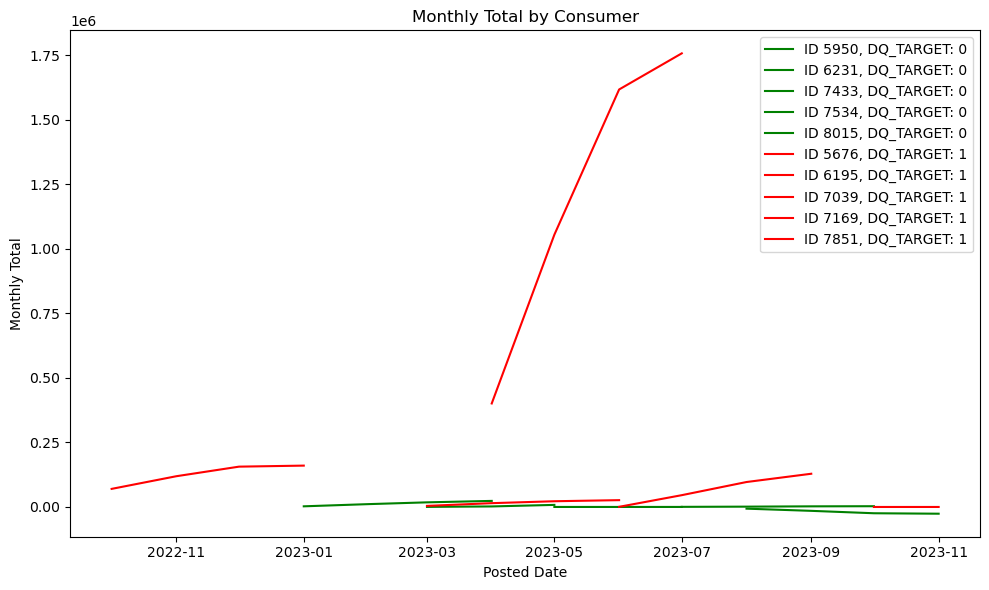

In [289]:
random.seed(10)

n=5

ids = np.random.choice(ids_0, size=n, replace=False)
ids2 = np.random.choice(ids_1,size=n,replace=False)

subset = monthly_summary[monthly_summary['prism_consumer_id'].isin(ids)]
subset2 = monthly_summary[monthly_summary['prism_consumer_id'].isin(ids2)]

plt.figure(figsize=(10, 6))

for pid, df in subset.groupby('prism_consumer_id'):
    plt.plot(df['posted_date'], df['monthly_balance'], label=f'ID {pid}, DQ_TARGET: 0',color='green')
    
for pid, df in subset2.groupby('prism_consumer_id'):
    plt.plot(df['posted_date'], df['monthly_balance'], label=f'ID {pid}, DQ_TARGET: 1',color='red')

plt.xlabel('Posted Date')
plt.ylabel('Monthly Total')
plt.title('Monthly Total by Consumer')
plt.legend()
plt.tight_layout()
plt.show()

In [290]:
monthly_summary

,prism_consumer_id,posted_date,starting_balance,monthly_total,trxndf_count,DQ_TARGET,monthly_balance
0,0,2021-03-01,320.37,10572.21,33,0.0,10892.58
1,0,2021-04-01,320.37,22105.53,69,0.0,32998.11
2,0,2021-05-01,320.37,11853.69,37,0.0,44851.80
3,0,2021-06-01,320.37,27231.45,85,0.0,72083.25
4,0,2021-07-01,320.37,23707.38,74,0.0,95790.63
...,...,...,...,...,...,...,...
74439,999,2020-11-01,2236.37,140891.31,63,0.0,237055.22
74440,999,2020-12-01,2236.37,351110.09,157,0.0,588165.31
74441,999,2021-01-01,2236.37,272837.14,122,0.0,861002.45
74442,999,2021-02-01,2236.37,339928.24,152,0.0,1200930.69


### mtotal_df

In [291]:
mtotal_df = monthly_summary.groupby('prism_consumer_id').agg(
        DQ_TARGET = ('DQ_TARGET', 'first'),
        monthly_mean=('monthly_total', 'mean'),
        monthly_max=('monthly_total', 'max'),
        monthly_min=('monthly_total', 'min'),
        trxndf_count = ('trxndf_count','first'),
        month_count=('monthly_total', 'count')
    )
mtotal_df

,DQ_TARGET,monthly_mean,monthly_max,monthly_min,trxndf_count,month_count
prism_consumer_id,,,,,,
0,0.0,1.867299e+04,27231.45,8970.36,33,7
1,0.0,1.481371e+05,208052.46,102375.02,31,7
10,0.0,4.015226e+04,60169.52,19781.76,31,7
100,0.0,5.399456e+04,63731.28,45142.99,19,6
1000,0.0,2.871107e+03,3524.25,476.25,5,7
...,...,...,...,...,...,...
995,0.0,2.053630e+06,3162590.31,670852.49,17,7
996,0.0,0.000000e+00,0.00,0.00,32,7
997,0.0,4.787867e+06,6756531.35,1404823.35,21,7


In [292]:
from sklearn.model_selection import train_test_split

X = mtotal_df.drop(columns='DQ_TARGET')
y = mtotal_df['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [293]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.6773498120150389
              precision    recall  f1-score   support

         0.0       0.97      0.61      0.75      2315
         1.0       0.16      0.77      0.26       216

    accuracy                           0.63      2531
   macro avg       0.56      0.69      0.50      2531
weighted avg       0.90      0.63      0.71      2531



In [294]:
cd_df = initial_df[['prism_consumer_id','amount','credit_or_debit']].groupby(['prism_consumer_id','credit_or_debit']).sum().reset_index()
cd_df

,prism_consumer_id,credit_or_debit,amount
0,0,CREDIT,14386.82
1,0,DEBIT,14908.41
2,1,CREDIT,24903.80
3,1,DEBIT,23098.37
4,10,CREDIT,20576.56
...,...,...,...
25008,9997,DEBIT,16702.92
25009,9998,CREDIT,14566.37
25010,9998,DEBIT,15399.47
25011,9999,CREDIT,31777.82


### cd_df

In [295]:
cd_df = (
    cd_df
    .pivot_table(
        index='prism_consumer_id',
        columns='credit_or_debit',
        values='amount',
        aggfunc='sum',
        fill_value=0
    )
    .assign(
        credit_debit_ratio=lambda x: x['CREDIT'] / (x['DEBIT'] + 1),
        net_flow=lambda x: x['CREDIT'] - x['DEBIT']
    )
)

In [296]:
cd_df = cd_df.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()
cd_df

,prism_consumer_id,CREDIT,DEBIT,credit_debit_ratio,net_flow,DQ_TARGET
0,0,14386.82,14908.41,0.964949,-521.59,0.0
1,1,24903.80,23098.37,1.078116,1805.43,0.0
2,10,20576.56,21766.60,0.945284,-1190.04,0.0
3,100,35236.84,39742.61,0.886604,-4505.77,0.0
4,1000,78353.07,77914.99,1.005610,438.08,0.0
...,...,...,...,...,...,...
12598,995,53309.15,31466.47,1.694103,21842.68,0.0
12607,996,222962.79,196249.61,1.136113,26713.18,0.0
12616,997,66176.94,81076.60,0.816217,-14899.66,0.0
12626,998,71714.74,66207.01,1.083173,5507.73,0.0


In [297]:
from sklearn.model_selection import train_test_split

X = cd_df.drop(columns = ['prism_consumer_id','DQ_TARGET'])
y = cd_df['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [298]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.6278297736181105
              precision    recall  f1-score   support

         0.0       0.95      0.38      0.54      2315
         1.0       0.11      0.80      0.19       216

    accuracy                           0.41      2531
   macro avg       0.53      0.59      0.36      2531
weighted avg       0.88      0.41      0.51      2531



In [299]:
net_df = initial_df[['prism_consumer_id','posted_date','category','credit_or_debit','amount']].copy()
net_df['amount'] = np.where(net_df['credit_or_debit'] == 'DEBIT', -net_df['amount'],net_df['amount'])
net_df['posted_date'] = pd.to_datetime(net_df['posted_date'])
net_df['month'] = net_df['posted_date'].dt.to_period('M')
mn_df = net_df.groupby(['prism_consumer_id','month']).agg(
        monthly_total=('amount', 'sum'),
        monthly_std =('amount','std')
    ).reset_index()
mn_df

,prism_consumer_id,month,monthly_total,monthly_std
0,0,2021-03,401.34,332.210452
1,0,2021-04,830.73,238.858943
2,0,2021-05,201.50,163.856341
3,0,2021-06,-2584.24,102.201363
4,0,2021-07,-71.38,187.201528
...,...,...,...,...
74473,9998,2023-10,15.86,252.389925
74474,9999,2023-05,3175.69,480.769524
74475,9999,2023-06,-236.42,428.377690
74476,9999,2023-07,-1288.34,428.713815


### monthly_features

In [300]:
monthly_features = mn_df.groupby(['prism_consumer_id']).agg(
    monthly_net_total=('monthly_total', 'sum'),
    monthly_net_avg=('monthly_total', 'mean'),
    monthly_net_max=('monthly_total', 'max'),
    monthly_net_min=('monthly_total', 'min'),
    monthly_std_avg=('monthly_std', 'mean')
).reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()
monthly_features['prism_consumer_id'] = monthly_features['prism_consumer_id'].astype(int)
mtotal_df = mtotal_df.reset_index()
mtotal_df['prism_consumer_id'] = mtotal_df['prism_consumer_id'].astype(int)
cd_df['prism_consumer_id'] = cd_df['prism_consumer_id'].astype(int)
monthly_features['net_range'] = monthly_features['monthly_net_max'] - monthly_features['monthly_net_min']
monthly_features

,prism_consumer_id,monthly_net_total,monthly_net_avg,monthly_net_max,monthly_net_min,monthly_std_avg,DQ_TARGET,net_range
0,0,-521.59,-74.512857,830.73,-2584.24,213.544425,0.0,3414.97
1,1,1805.43,257.918571,1109.02,-940.73,292.763392,0.0,2049.75
2,10,-1190.04,-170.005714,431.40,-971.45,260.603079,0.0,1402.85
3,100,-4505.77,-750.961667,1276.72,-3332.81,832.186871,0.0,4609.53
4,1000,438.08,62.582857,2982.67,-2884.56,1223.790895,0.0,5867.23
...,...,...,...,...,...,...,...,...
12598,995,21842.68,3120.382857,10212.74,-3244.20,1016.422674,0.0,13456.94
12607,996,26713.18,3816.168571,41464.50,-16811.41,2623.765971,0.0,58275.91
12616,997,-14899.66,-2128.522857,206.99,-3741.45,745.079512,0.0,3948.44
12626,998,5507.73,786.818571,3359.83,-1022.35,537.836676,0.0,4382.18


In [301]:
from sklearn.model_selection import train_test_split

X = monthly_features.drop(columns=['prism_consumer_id','DQ_TARGET'])
y = monthly_features['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [302]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.6050277339575594
              precision    recall  f1-score   support

         0.0       0.96      0.36      0.53      2285
         1.0       0.11      0.82      0.19       215

    accuracy                           0.40      2500
   macro avg       0.53      0.59      0.36      2500
weighted avg       0.88      0.40      0.50      2500



In [303]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))


ROC AUC: 0.6840506844435398


In [304]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc'
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [305]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC: 0.6895353926008855
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      2285
         1.0       0.56      0.02      0.04       215

    accuracy                           0.91      2500
   macro avg       0.74      0.51      0.50      2500
weighted avg       0.88      0.91      0.88      2500



In [306]:
import pandas as pd

importance = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance.head(10)

monthly_net_total    0.191621
monthly_net_max      0.188124
net_range            0.170834
monthly_std_avg      0.152746
monthly_net_avg      0.149985
monthly_net_min      0.146690
dtype: float32

### catsum_df

In [307]:
initial_df['amount'] = np.where(initial_df['credit_or_debit'] == 'DEBIT', -initial_df['amount'],initial_df['amount'])
cat_df = initial_df.groupby(['prism_consumer_id','category'])['amount'].sum().reset_index()

In [308]:
cat_pivot = (
    cat_df
    .pivot(
        index='prism_consumer_id',
        columns='category',
        values='amount'
    )
    .fillna(0)
)
cat_pivot

category,ACCOUNT_FEES,ATM_CASH,AUTOMOTIVE,AUTO_LOAN,BANKING_CATCH_ALL,BILLS_UTILITIES,BNPL,CHILD_DEPENDENTS,CORPORATE_PAYMENTS,CREDIT_CARD_PAYMENT,...,REFUND,RENT,RISK_CATCH_ALL,RTO_LTO,SELF_TRANSFER,TAX,TIME_OR_STUFF,TRANSPORATION,TRAVEL,UNEMPLOYMENT_BENEFITS
prism_consumer_id,,,,,,,,,,,,,,,,,,,,,
0,0.00,-540.00,-527.15,0.00,-1980.00,0.00,0.00,0.0,0.0,0.00,...,19.96,0.0,0.0,0.0,1.741030e+03,2603.52,0.0,-2.48,-108.75,0.0
1,0.00,-6999.13,-195.18,0.00,0.00,0.00,-251.43,0.0,0.0,0.00,...,2.42,0.0,0.0,0.0,0.000000e+00,2325.40,0.0,-51.80,0.00,0.0
10,0.00,-4112.00,-483.06,0.00,0.00,0.00,0.00,0.0,0.0,-180.00,...,92.33,-103.0,0.0,0.0,-5.684342e-14,0.00,0.0,-35.04,0.00,0.0
100,0.00,-200.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,-16188.17,...,11.75,0.0,0.0,0.0,-4.202680e+03,0.00,0.0,0.00,0.00,0.0
1000,0.00,0.00,-204.03,0.00,0.00,0.00,0.00,0.0,0.0,-14756.05,...,1.37,0.0,0.0,0.0,-3.162727e+04,0.00,0.0,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.00,-1260.18,-115.56,-672.78,0.00,-53.98,-167.60,0.0,0.0,-512.48,...,0.00,0.0,0.0,0.0,0.000000e+00,0.00,0.0,0.00,0.00,0.0
9996,0.00,0.00,-75.39,0.00,-184.34,0.00,0.00,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.000000e+00,0.00,0.0,0.00,-27.69,0.0
9997,-10.50,-1053.25,-217.60,-962.16,0.00,-230.00,-729.08,0.0,0.0,-829.00,...,335.00,0.0,0.0,0.0,0.000000e+00,0.00,0.0,0.00,-136.34,0.0


In [309]:
outflows = cat_pivot.clip(upper=0).abs()
inflows  = cat_pivot.clip(lower=0)

cat_features = pd.DataFrame(index=cat_pivot.index)

cat_features['total_outflows'] = outflows.sum(axis=1)
cat_features['total_inflows']  = inflows.sum(axis=1)
cat_features['net_flow']       = cat_pivot.sum(axis=1)


In [310]:
for col in outflows.columns:
    cat_features[f'{col}_outflow_ratio'] = (
        outflows[col] / (cat_features['total_outflows'] + 1)
    )


In [311]:
# Income reliance
cat_features['paycheck_ratio'] = (
    inflows.get('PAYCHECK', 0) / (cat_features['total_inflows'] + 1)
)

# Cash usage
cat_features['atm_cash_ratio'] = (
    outflows.get('ATM_CASH', 0) / (cat_features['total_outflows'] + 1)
)

# Entertainment vs essentials proxy
cat_features['entertainment_ratio'] = (
    outflows.get('ENTERTAINMENT', 0) / (cat_features['total_outflows'] + 1)
)

# Refund dependence
cat_features['refund_ratio'] = (
    inflows.get('REFUND', 0) / (cat_features['total_inflows'] + 1)
)

In [312]:
outflows = outflows.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()
outflows

,prism_consumer_id,ACCOUNT_FEES,ATM_CASH,AUTOMOTIVE,AUTO_LOAN,BANKING_CATCH_ALL,BILLS_UTILITIES,BNPL,CHILD_DEPENDENTS,CORPORATE_PAYMENTS,...,RENT,RISK_CATCH_ALL,RTO_LTO,SELF_TRANSFER,TAX,TIME_OR_STUFF,TRANSPORATION,TRAVEL,UNEMPLOYMENT_BENEFITS,DQ_TARGET
0,0,0.0,540.00,527.15,0.0,1980.00,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,0.000000e+00,0.0,0.0,2.48,108.75,0.0,0.0
1,1,0.0,6999.13,195.18,0.0,0.00,0.00,251.43,0.0,0.0,...,0.00,0.0,0.0,0.000000e+00,0.0,0.0,51.80,0.00,0.0,0.0
2,10,0.0,4112.00,483.06,0.0,0.00,0.00,0.00,0.0,0.0,...,103.00,0.0,0.0,5.684342e-14,0.0,0.0,35.04,0.00,0.0,0.0
3,100,0.0,200.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,4.202680e+03,0.0,0.0,0.00,0.00,0.0,0.0
4,1000,0.0,0.00,204.03,0.0,0.00,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,3.162727e+04,0.0,0.0,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12598,995,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,...,5670.79,0.0,0.0,0.000000e+00,0.0,0.0,0.00,0.00,0.0,0.0
12607,996,0.0,11500.00,1090.58,0.0,67.79,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,0.000000e+00,0.0,0.0,12.00,5433.00,0.0,0.0
12616,997,0.0,11640.00,0.00,0.0,300.00,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,4.048990e+03,0.0,0.0,0.00,0.00,0.0,0.0
12626,998,0.0,1130.57,1958.32,0.0,3441.84,881.68,568.81,209.4,0.0,...,693.95,0.0,0.0,0.000000e+00,0.0,0.0,63.50,496.28,0.0,0.0


In [313]:
cat_features = cat_features.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()

In [314]:
from sklearn.model_selection import train_test_split

X = outflows.drop(columns=['prism_consumer_id','DQ_TARGET'])
y = outflows['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [315]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.6716342692584594
              precision    recall  f1-score   support

         0.0       0.95      0.53      0.68      2315
         1.0       0.13      0.73      0.21       216

    accuracy                           0.54      2531
   macro avg       0.54      0.63      0.45      2531
weighted avg       0.88      0.54      0.64      2531



In [316]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))


ROC AUC: 0.7397808175345972


In [317]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc'
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [318]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC: 0.7454403647708183
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      2315
         1.0       0.56      0.04      0.08       216

    accuracy                           0.92      2531
   macro avg       0.74      0.52      0.52      2531
weighted avg       0.89      0.92      0.88      2531



In [319]:
import pandas as pd

importance = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance.head(5)

OVERDRAFT              0.040062
ACCOUNT_FEES           0.038719
CREDIT_CARD_PAYMENT    0.031763
RTO_LTO                0.031227
INSURANCE              0.031061
dtype: float32

In [320]:
categories_with_weight = importance[importance > 0].index.tolist()
categories_with_weight = categories_with_weight + ['prism_consumer_id']

In [321]:
add_df = cat_features[['prism_consumer_id','refund_ratio','paycheck_ratio']].copy()
add_df['prism_consumer_id'] = add_df['prism_consumer_id'].astype(int)
outflows['prism_consumer_id'] = outflows['prism_consumer_id'].astype(int)
out_df = outflows[categories_with_weight].copy()
out_df

,OVERDRAFT,ACCOUNT_FEES,CREDIT_CARD_PAYMENT,RTO_LTO,INSURANCE,AUTOMOTIVE,BNPL,INVESTMENT,GROCERIES,ENTERTAINMENT,...,RENT,GOVERNMENT_SERVICES,TAX,TRANSPORATION,FITNESS,BANKING_CATCH_ALL,LEGAL,GIFTS_DONATIONS,RISK_CATCH_ALL,prism_consumer_id
0,0.0,0.0,0.00,0.0,0.00,527.15,0.00,0.0,997.63,151.71,...,0.00,0.0,0.0,2.48,150.60,1980.00,0.0,0.0,0.0,0
1,0.0,0.0,0.00,0.0,0.00,195.18,251.43,0.0,427.27,275.25,...,0.00,0.0,0.0,51.80,0.00,0.00,0.0,0.0,0.0,1
2,0.0,0.0,180.00,0.0,0.00,483.06,0.00,0.0,621.79,107.64,...,103.00,0.0,0.0,35.04,0.00,0.00,0.0,50.0,0.0,10
3,0.0,0.0,16188.17,0.0,1942.76,0.00,0.00,0.0,403.50,0.00,...,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,100
4,0.0,0.0,14756.05,0.0,0.00,204.03,0.00,0.0,0.00,0.00,...,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12598,0.0,0.0,14832.19,0.0,355.27,0.00,0.00,0.0,472.66,0.00,...,5670.79,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,995
12607,0.0,0.0,17665.91,0.0,0.00,1090.58,0.00,3000.0,1074.43,1330.34,...,0.00,1807.4,0.0,12.00,0.00,67.79,0.0,0.0,0.0,996
12616,0.0,0.0,6121.09,0.0,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.0,0.0,0.00,0.00,300.00,0.0,0.0,0.0,997
12626,0.0,0.0,300.00,0.0,1047.42,1958.32,568.81,0.0,4907.57,625.97,...,693.95,40.0,0.0,63.50,75.49,3441.84,0.0,0.0,0.0,998


### catavg_df

In [322]:
initial_df['amount'] = np.where(initial_df['credit_or_debit'] == 'DEBIT', -initial_df['amount'],initial_df['amount'])
cat_df = initial_df.groupby(['prism_consumer_id','category'])['amount'].mean().reset_index()
cat_df

,prism_consumer_id,category,amount
0,0,ATM_CASH,180.000000
1,0,AUTOMOTIVE,25.102381
2,0,BANKING_CATCH_ALL,396.000000
3,0,DEPOSIT,500.000000
4,0,ENTERTAINMENT,25.285000
...,...,...,...
239827,9999,MISCELLANEOUS,77.280526
239828,9999,PAYCHECK,2563.146667
239829,9999,REFUND,23.760000
239830,9999,TRANSPORATION,9.480714


In [323]:
cat_pivot = (
    cat_df
    .pivot(
        index='prism_consumer_id',
        columns='category',
        values='amount'
    )
    .fillna(0)
)
cat_pivot.columns = cat_pivot.columns + "_trxnavg"
cat_pivot = cat_pivot.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()
cat_pivot['prism_consumer_id'] = cat_pivot['prism_consumer_id'].astype(int)
cat_pivot

,prism_consumer_id,ACCOUNT_FEES_trxnavg,ATM_CASH_trxnavg,AUTOMOTIVE_trxnavg,AUTO_LOAN_trxnavg,BANKING_CATCH_ALL_trxnavg,BILLS_UTILITIES_trxnavg,BNPL_trxnavg,CHILD_DEPENDENTS_trxnavg,CORPORATE_PAYMENTS_trxnavg,...,RENT_trxnavg,RISK_CATCH_ALL_trxnavg,RTO_LTO_trxnavg,SELF_TRANSFER_trxnavg,TAX_trxnavg,TIME_OR_STUFF_trxnavg,TRANSPORATION_trxnavg,TRAVEL_trxnavg,UNEMPLOYMENT_BENEFITS_trxnavg,DQ_TARGET
0,0,0.0,180.000000,25.102381,0.0,396.00,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,116.685652,867.840,0.000000,2.480000,54.375000,0.0,0.0
1,1,0.0,199.975143,27.882857,0.0,0.00,0.000000,17.959286,0.0,0.0,...,0.000000,0.0,0.0,233.410256,1162.700,0.000000,25.900000,0.000000,0.0,0.0
2,10,0.0,228.444444,21.002609,0.0,0.00,0.000000,0.000000,0.0,0.0,...,103.000000,0.0,0.0,237.568750,0.000,0.000000,17.520000,0.000000,0.0,0.0
3,100,0.0,200.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,547.296667,0.000,0.000000,0.000000,0.000000,0.0,0.0
4,1000,0.0,0.000000,34.005000,0.0,0.00,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,828.920370,0.000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12598,995,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,...,1134.158000,0.0,0.0,1250.937000,626.432,0.000000,0.000000,0.000000,0.0,0.0
12607,996,0.0,1437.500000,35.180000,0.0,67.79,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,3532.145542,0.000,0.000000,12.000000,493.909091,0.0,0.0
12616,997,0.0,223.846154,0.000000,0.0,300.00,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,940.464154,2516.000,20.149683,0.000000,0.000000,0.0,0.0
12626,998,0.0,94.214167,41.666383,0.0,573.64,146.946667,43.754615,34.9,0.0,...,231.316667,0.0,0.0,759.527885,2991.340,0.000000,12.700000,248.140000,0.0,0.0


In [324]:
from sklearn.model_selection import train_test_split

X = cat_pivot.drop(columns=['prism_consumer_id','DQ_TARGET'])
y = cat_pivot['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [325]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.683237341012719
              precision    recall  f1-score   support

         0.0       0.96      0.56      0.71      2315
         1.0       0.13      0.72      0.22       216

    accuracy                           0.57      2531
   macro avg       0.54      0.64      0.46      2531
weighted avg       0.88      0.57      0.66      2531



In [326]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))


ROC AUC: 0.748894088472922


In [327]:
# from sklearn.metrics import roc_auc_score, classification_report

# y_pred = xgb.predict(X_test)
# y_prob = xgb.predict_proba(X_test)[:, 1]

# print("ROC AUC:", roc_auc_score(y_test, y_prob))
# print(classification_report(y_test, y_pred))

### Income_Df

In [328]:
mapping = dict(zip(cat_map["category_id"], cat_map["category"]))
trxndf["category"] = trxndf["category"].replace(mapping)

income_categories = [
    'PAYCHECK',
    'DEPOSIT',
    'UNEMPLOYMENT_BENEFITS',
    'OTHER_BENEFITS',
    'PENSION',
    'INVESTMENT_INCOME'
]

income_df = trxndf[
    trxndf['category'].isin(income_categories)
].copy()
income_df['prism_transaction_id'].duplicated().sum()
income_df['posted_date'] = pd.to_datetime(income_df['posted_date'])

In [329]:
trxndf

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,MISCELLANEOUS,0.05,CREDIT,2021-04-16
1,3023,1,LOAN,481.56,CREDIT,2021-04-30
2,3023,2,MISCELLANEOUS,0.05,CREDIT,2021-05-16
3,3023,3,MISCELLANEOUS,0.07,CREDIT,2021-06-16
4,3023,4,MISCELLANEOUS,0.06,CREDIT,2021-07-16
...,...,...,...,...,...,...
6407316,10533,6405304,BILLS_UTILITIES,4.96,DEBIT,2022-03-11
6407317,10533,6405305,LOAN,63.48,DEBIT,2022-03-30
6407318,10533,6405306,LOAN,53.99,DEBIT,2022-03-30
6407319,10533,6405307,LOAN,175.98,DEBIT,2022-03-31


In [330]:
income_time = (
    income_df
    .groupby('prism_consumer_id')
    .agg(
        first_income_date=('posted_date', 'min'),
        last_income_date=('posted_date', 'max')
    )
    .reset_index()
)

income_time['income_span_days'] = (
    income_time['last_income_date'] - income_time['first_income_date']
).dt.days

In [331]:
income_df = income_time[['prism_consumer_id','income_span_days']]
income_df['prism_consumer_id'] = income_time['prism_consumer_id'].astype(int)
income_df

,prism_consumer_id,income_span_days
0,0,176
1,1,168
2,10,168
3,100,169
4,1000,177
...,...,...
13873,9995,77
13874,9996,61
13875,9997,84
13876,9998,71


### Try the counts of negative categories, look at external transfer as well

remove credit cards, loans, lines of credit

In [332]:
acctdf

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.57
1,3023,1,CHECKING,2021-08-31,225.95
2,4416,2,SAVINGS,2022-03-31,15157.17
3,4416,3,CHECKING,2022-03-31,66.42
4,4227,4,CHECKING,2021-07-31,7042.90
...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.75
24462,11615,24462,SAVINGS,2022-03-30,5.00
24463,11615,24463,CHECKING,2022-03-30,1956.46
24464,12210,24464,CHECKING,2022-03-28,2701.51


## Main model testing

In [333]:
trxndf

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,MISCELLANEOUS,0.05,CREDIT,2021-04-16
1,3023,1,LOAN,481.56,CREDIT,2021-04-30
2,3023,2,MISCELLANEOUS,0.05,CREDIT,2021-05-16
3,3023,3,MISCELLANEOUS,0.07,CREDIT,2021-06-16
4,3023,4,MISCELLANEOUS,0.06,CREDIT,2021-07-16
...,...,...,...,...,...,...
6407316,10533,6405304,BILLS_UTILITIES,4.96,DEBIT,2022-03-11
6407317,10533,6405305,LOAN,63.48,DEBIT,2022-03-30
6407318,10533,6405306,LOAN,53.99,DEBIT,2022-03-30
6407319,10533,6405307,LOAN,175.98,DEBIT,2022-03-31


In [334]:
cat_pivot= cat_pivot.drop(columns='DQ_TARGET')

In [335]:
main_df= monthly_features.merge(mtotal_df,on='prism_consumer_id')
main_df['DQ_TARGET'] = main_df['DQ_TARGET_x']
main_df = main_df.drop(columns=['DQ_TARGET_x','DQ_TARGET_y'])
cd_df = cd_df.drop(columns=['net_flow','DQ_TARGET'])
main_df= main_df.merge(cd_df,on='prism_consumer_id')
main_df= main_df.merge(add_df,on='prism_consumer_id')
main_df= main_df.merge(out_df,on='prism_consumer_id')
main_df= main_df.merge(income_df,on='prism_consumer_id')
main_df= main_df.merge(cat_pivot,on='prism_consumer_id')
main_df

,prism_consumer_id,monthly_net_total,monthly_net_avg,monthly_net_max,monthly_net_min,monthly_std_avg,net_range,monthly_mean,monthly_max,monthly_min,...,REFUND_trxnavg,RENT_trxnavg,RISK_CATCH_ALL_trxnavg,RTO_LTO_trxnavg,SELF_TRANSFER_trxnavg,TAX_trxnavg,TIME_OR_STUFF_trxnavg,TRANSPORATION_trxnavg,TRAVEL_trxnavg,UNEMPLOYMENT_BENEFITS_trxnavg
0,0,-521.59,-74.512857,830.73,-2584.24,213.544425,3414.97,1.867299e+04,27231.45,8970.36,...,19.960000,0.000000,0.0,0.0,116.685652,867.840,0.000000,2.480000,54.375000,0.0
1,1,1805.43,257.918571,1109.02,-940.73,292.763392,2049.75,1.481371e+05,208052.46,102375.02,...,2.420000,0.000000,0.0,0.0,233.410256,1162.700,0.000000,25.900000,0.000000,0.0
2,10,-1190.04,-170.005714,431.40,-971.45,260.603079,1402.85,4.015226e+04,60169.52,19781.76,...,18.466000,103.000000,0.0,0.0,237.568750,0.000,0.000000,17.520000,0.000000,0.0
3,100,-4505.77,-750.961667,1276.72,-3332.81,832.186871,4609.53,5.399456e+04,63731.28,45142.99,...,1.468750,0.000000,0.0,0.0,547.296667,0.000,0.000000,0.000000,0.000000,0.0
4,1000,438.08,62.582857,2982.67,-2884.56,1223.790895,5867.23,2.871107e+03,3524.25,476.25,...,1.370000,0.000000,0.0,0.0,828.920370,0.000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9589,995,21842.68,3120.382857,10212.74,-3244.20,1016.422674,13456.94,2.053630e+06,3162590.31,670852.49,...,1.463333,1134.158000,0.0,0.0,1250.937000,626.432,0.000000,0.000000,0.000000,0.0
9590,996,26713.18,3816.168571,41464.50,-16811.41,2623.765971,58275.91,0.000000e+00,0.00,0.00,...,2.944444,0.000000,0.0,0.0,3532.145542,0.000,0.000000,12.000000,493.909091,0.0
9591,997,-14899.66,-2128.522857,206.99,-3741.45,745.079512,3948.44,4.787867e+06,6756531.35,1404823.35,...,14.420000,0.000000,0.0,0.0,940.464154,2516.000,20.149683,0.000000,0.000000,0.0
9592,998,5507.73,786.818571,3359.83,-1022.35,537.836676,4382.18,7.987620e+05,1116887.94,275774.80,...,9.546429,231.316667,0.0,0.0,759.527885,2991.340,0.000000,12.700000,248.140000,0.0


In [336]:
print("monthly_features:", monthly_features["prism_consumer_id"].nunique())
print("mtotal_df:", mtotal_df["prism_consumer_id"].nunique())
print("cd_df:", cd_df["prism_consumer_id"].nunique())
print("add_df:", add_df["prism_consumer_id"].nunique())
print("out_df:", out_df["prism_consumer_id"].nunique())
print("income_df:", income_df["prism_consumer_id"].nunique())
print("cat_pivot:", cat_pivot["prism_consumer_id"].nunique())



monthly_features: 10000
mtotal_df: 10122
cd_df: 10122
add_df: 10122
out_df: 10122
income_df: 13878
cat_pivot: 10122


In [337]:
from sklearn.model_selection import train_test_split

X = main_df.drop(columns=['prism_consumer_id','DQ_TARGET'])
y = main_df['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [338]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.7412052803426606
              precision    recall  f1-score   support

         0.0       0.96      0.66      0.78      2191
         1.0       0.17      0.72      0.27       208

    accuracy                           0.67      2399
   macro avg       0.57      0.69      0.53      2399
weighted avg       0.89      0.67      0.74      2399



In [339]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))


ROC AUC: 0.8175073728188744


In [340]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=600,          # more trees
    max_depth=6,               # slightly deeper interactions
    learning_rate=0.03,        # slower learning → better generalization
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=3,        # reduce noisy splits
    gamma=0.1,                 # require meaningful gain
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=1.0,            # L2 regularization
    eval_metric="auc",
    tree_method="hist",
    random_state=42
)


xgb.fit(X_train, y_train)
from sklearn.metrics import roc_auc_score, classification_report

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC: 0.8056143138012147
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95      2191
         1.0       0.48      0.06      0.11       208

    accuracy                           0.91      2399
   macro avg       0.70      0.53      0.53      2399
weighted avg       0.88      0.91      0.88      2399



In [341]:
import pandas as pd

importance = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance

month_count                      0.102937
monthly_min                      0.022604
OVERDRAFT_trxnavg                0.015318
DEBT_trxnavg                     0.014484
CREDIT_CARD_PAYMENT              0.013888
                                   ...   
GOVERNMENT_SERVICES              0.006674
RISK_CATCH_ALL_trxnavg           0.005396
UNEMPLOYMENT_BENEFITS_trxnavg    0.002333
CORPORATE_PAYMENTS_trxnavg       0.000000
RISK_CATCH_ALL                   0.000000
Length: 102, dtype: float32

In [342]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# X = dataframe of features
# y = target column (0/1)

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- XGBoost Model ---
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    random_state=42
)

# --- RFE ---
rfe = RFE(
    estimator=xgb_model,
    n_features_to_select=50,
    step=1   # speed up elimination
)

rfe.fit(X_train, y_train)

# Selected feature names
selected_features = X.columns[rfe.support_]
print("Selected Features:", list(selected_features))

# Transform datasets
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# --- Train final model on reduced features ---
xgb_model.fit(X_train_rfe, y_train)

# --- Predict probabilities ---
y_probs = xgb_model.predict_proba(X_test_rfe)[:, 1]

# --- AUC ---
auc_score = roc_auc_score(y_test, y_probs)
print("Test ROC-AUC:", auc_score)


Selected Features: ['monthly_net_total', 'monthly_net_avg', 'monthly_net_max', 'monthly_net_min', 'monthly_mean', 'monthly_max', 'monthly_min', 'month_count', 'DEBIT', 'credit_debit_ratio', 'refund_ratio', 'paycheck_ratio', 'OVERDRAFT', 'ACCOUNT_FEES', 'CREDIT_CARD_PAYMENT', 'INSURANCE', 'AUTOMOTIVE', 'INVESTMENT', 'ENTERTAINMENT', 'TRAVEL', 'FOOD_AND_BEVERAGES', 'LOAN', 'CHILD_DEPENDENTS', 'EXTERNAL_TRANSFER', 'HOME_IMPROVEMENT', 'GAMBLING', 'ATM_CASH', 'RENT', 'FITNESS', 'income_span_days', 'ATM_CASH_trxnavg', 'AUTOMOTIVE_trxnavg', 'BILLS_UTILITIES_trxnavg', 'BNPL_trxnavg', 'CHILD_DEPENDENTS_trxnavg', 'CREDIT_CARD_PAYMENT_trxnavg', 'DEBT_trxnavg', 'ENTERTAINMENT_trxnavg', 'EXTERNAL_TRANSFER_trxnavg', 'FOOD_AND_BEVERAGES_trxnavg', 'GAMBLING_trxnavg', 'GENERAL_MERCHANDISE_trxnavg', 'INVESTMENT_trxnavg', 'LOAN_trxnavg', 'MISCELLANEOUS_trxnavg', 'OVERDRAFT_trxnavg', 'PAYCHECK_trxnavg', 'PENSION_trxnavg', 'SELF_TRANSFER_trxnavg', 'TRAVEL_trxnavg']
Test ROC-AUC: 0.8064797696204098


# Heidi

In [343]:
# columns I will need: credit/debit, amount, posted date, evaluation date, prism consumer id, DQ_TARGET
merged = pd.merge(consdf.dropna(), trxndf, on='prism_consumer_id', how='left')
merged.head()

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,0,2021-09-01,726.0,0.0,136696,MISCELLANEOUS,0.09,CREDIT,2021-03-19
1,0,2021-09-01,726.0,0.0,136697,MISCELLANEOUS,0.05,CREDIT,2021-04-16
2,0,2021-09-01,726.0,0.0,136698,MISCELLANEOUS,0.06,CREDIT,2021-05-21
3,0,2021-09-01,726.0,0.0,136699,MISCELLANEOUS,0.04,CREDIT,2021-06-18
4,0,2021-09-01,726.0,0.0,136700,MISCELLANEOUS,0.02,CREDIT,2021-07-16


In [344]:
merged = merged[merged['posted_date'] <= merged['evaluation_date']]
credit_only = merged[merged['credit_or_debit'] == 'CREDIT'].copy()
credit_only['posted_date'] = pd.to_datetime(credit_only['posted_date'])
credit_only['Year-Month'] = credit_only['posted_date'].dt.to_period('M')
debt_only = trxndf[trxndf['credit_or_debit']=='DEBIT']
monthly_inflow = credit_only.groupby(['prism_consumer_id', 'Year-Month'])['amount'].sum().reset_index(name='monthly_inflow')
consdf['Evaluation Month'] = consdf['evaluation_date'].dt.to_period('M')
with_eval_month = pd.merge(consdf, monthly_inflow, on='prism_consumer_id', how='left')

In [345]:
with_eval_month['months_diff'] = (
    (with_eval_month['Evaluation Month'].dt.year - with_eval_month['Year-Month'].dt.year) * 12 +
    (with_eval_month['Evaluation Month'].dt.month - with_eval_month['Year-Month'].dt.month)
)
last_year = with_eval_month[(with_eval_month['months_diff'] >= 1) & (with_eval_month['months_diff'] <= 12)]
sum_yearly_inflow = last_year.groupby('prism_consumer_id')['monthly_inflow'].sum().reset_index(name='avg_yearly_inflow')
year_std = last_year.groupby('prism_consumer_id')['monthly_inflow'].std().reset_index()
year_std.columns = ['prism_consumer_id', 'std_inflow']

In [346]:
# Trend: Is income increasing or decreasing?
def calculate_trend(group):
    if len(group) < 2:
        return 0
    months = group['months_diff'].values
    inflows = group['monthly_inflow'].values
    return np.polyfit(months, inflows, 1)[0]  # slope

trend = last_year.groupby('prism_consumer_id').apply(calculate_trend, include_groups=False).reset_index()
trend.columns = ['prism_consumer_id', 'trend']
num_transactions = last_year.groupby('prism_consumer_id').size().reset_index()
num_transactions.columns = ['prism_consumer_id', 'num_transactions']

In [347]:
debt_only

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
41,3023,41,SELF_TRANSFER,60.00,DEBIT,2021-04-14
42,3023,42,EXTERNAL_TRANSFER,12.38,DEBIT,2021-04-20
43,3023,43,SELF_TRANSFER,150.00,DEBIT,2021-05-02
44,3023,44,SELF_TRANSFER,200.00,DEBIT,2021-05-03
45,3023,45,EXTERNAL_TRANSFER,67.07,DEBIT,2021-08-19
...,...,...,...,...,...,...
6407316,10533,6405304,BILLS_UTILITIES,4.96,DEBIT,2022-03-11
6407317,10533,6405305,LOAN,63.48,DEBIT,2022-03-30
6407318,10533,6405306,LOAN,53.99,DEBIT,2022-03-30
6407319,10533,6405307,LOAN,175.98,DEBIT,2022-03-31


In [348]:
debt_only = trxndf[trxndf['credit_or_debit'] == 'DEBIT'].copy()
debt_only['posted_date'] = pd.to_datetime(debt_only['posted_date'])
# debt_only['category'] = debt_only['category'].astype(int)

# debt_with_category = pd.merge(debt_only, cat_map, left_on='category', right_on='category_id', how='left')[['prism_consumer_id',\
#     'prism_transaction_id', 'amount', 'credit_or_debit', 'posted_date', 'category_id', 'category_y']]
debt_with_category = debt_only.rename(columns={'category_y':'category'})
groceries_only = debt_with_category[debt_with_category['category']=='GROCERIES']

debt_with_eval = pd.merge(groceries_only, consdf[['prism_consumer_id', 'evaluation_date']], on='prism_consumer_id', how='left')

# Filter for transactions in the 3 months before evaluation_date
debt_with_eval['months_before_eval'] = (
    (debt_with_eval['evaluation_date'].dt.year - debt_with_eval['posted_date'].dt.year) * 12 +
    (debt_with_eval['evaluation_date'].dt.month - debt_with_eval['posted_date'].dt.month)
)

debt_9m = debt_with_eval[(debt_with_eval['months_before_eval'] >= 0) & 
                          (debt_with_eval['months_before_eval'] < 9)]

# total spend of groceries per consumer over a 9 month window (last 9 months before eval date)
total_spend_groceries_9m = debt_9m.groupby('prism_consumer_id')['amount'].sum().reset_index()
total_spend_groceries_9m.columns = ['prism_consumer_id', 'sum_groceries_9m']
total_spend_groceries_9m

,prism_consumer_id,sum_groceries_9m
0,0,997.63
1,1,427.27
2,10,621.79
3,10000,3847.95
4,10001,683.59
...,...,...
11904,9994,2434.95
11905,9995,165.78
11906,9996,52.22
11907,9998,435.26


In [349]:
# total spend of dining per consumer over a month window (last month before eval date)
dining_only = debt_with_category[debt_with_category['category']=='FOOD_AND_BEVERAGES']

debt_with_eval_dining = pd.merge(dining_only, consdf[['prism_consumer_id', 'evaluation_date']], on='prism_consumer_id', how='left')

# Filter for transactions in the 6 months before evaluation_date
debt_with_eval_dining['months_before_eval'] = (
    (debt_with_eval_dining['evaluation_date'].dt.year - debt_with_eval_dining['posted_date'].dt.year) * 12 +
    (debt_with_eval_dining['evaluation_date'].dt.month - debt_with_eval_dining['posted_date'].dt.month)
)

debt_6m = debt_with_eval_dining[(debt_with_eval_dining['months_before_eval'] >= 0) & 
                          (debt_with_eval_dining['months_before_eval'] < 6)]

# total spend of groceries per consumer over a 6 month window (last 6 months before eval date)
total_spend_dining_6m = debt_6m.groupby('prism_consumer_id')['amount'].sum().reset_index()
total_spend_dining_6m.columns = ['prism_consumer_id', 'sum_dining_6m']
total_spend_dining_6m #702, 6

,prism_consumer_id,sum_dining_6m
0,0,3746.79
1,1,308.65
2,10,3010.31
3,10000,1563.55
4,10001,1864.00
...,...,...
12350,9995,387.16
12351,9996,107.83
12352,9997,66.41
12353,9998,300.74


In [350]:
# merge evaluation date ONCE
tx = debt_with_category.merge(
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

tx = tx[tx['credit_or_debit'] == 'DEBIT']
tx['amount'] = tx['amount'].abs()

# numerator
total_spend_gambling = tx[tx['category'] == 'GAMBLING'].groupby('prism_consumer_id')['amount'].sum()

# denominator
total_spend_all = tx.groupby('prism_consumer_id')['amount'].sum()

pct_spend_gambling = (total_spend_gambling / total_spend_all).fillna(0).reset_index(name='pct_spend_gambling')


In [351]:
essentials = ['RENT', 'MORTGAGE', 'BILLS_UTILITIES', 'ESSENTIAL_SERVICES', 'GROCERIES', 'AUTOMOTIVE', 'TRANSPORTATION', \
'HEALTHCARE_MEDICAL', 'INSURANCE', 'CHILD_DEPENDENTS', 'PETS', 'TAX', 'LOAN', 'AUTO_LOAN', 'DEBT', 'CREDIT_CARD_PAYMENT', \
'EDUCATION', 'LEGAL', 'GOVERNMENT_SERVICES']

total_spend_essentials = tx[tx['category'].isin(essentials)].groupby('prism_consumer_id')['amount'].sum()

pct_spend_essentials = (total_spend_essentials / total_spend_all).reset_index()

pct_spend_essentials = pct_spend_essentials.rename(columns={'amount':'pct_spend_essentials'})

In [352]:
# # change in groceries per consumer from the 3 most recent months to the prior 3-6 months before evaluation date
# lowers AUC from 0.721 to 0.71

# recent 3 months (0–2)
recent_3m = debt_with_eval[(debt_with_eval['months_before_eval'] >= 0) & (debt_with_eval['months_before_eval'] < 3)]

recent_spend = recent_3m.groupby('prism_consumer_id')['amount'].sum().reset_index(name='groceries_0_3m')

# prior 3 months (3–5)
prior_3m = debt_with_eval[(debt_with_eval['months_before_eval'] >= 3) & (debt_with_eval['months_before_eval'] < 6)]

prior_spend = prior_3m.groupby('prism_consumer_id')['amount'].sum().reset_index(name='groceries_3_6m')

# merge and compute delta
delta_groceries_3m = recent_spend.merge(
    prior_spend,
    on='prism_consumer_id',
    how='outer'
).fillna(0)

delta_groceries_3m['delta_groceries_3m'] = delta_groceries_3m['groceries_0_3m'] - delta_groceries_3m['groceries_3_6m']

delta_groceries_3m = delta_groceries_3m[['prism_consumer_id', 'delta_groceries_3m']]

utilities = ['BILLS_UTILITIES', 'ESSENTIAL_SERVICES']

total_spend_utilities = tx[tx['category'].isin(utilities)].groupby('prism_consumer_id')['amount'].sum()

pct_spend_utilities = (total_spend_utilities / total_spend_all).reset_index()

pct_spend_utilities = pct_spend_utilities.rename(columns={'amount':'pct_spend_utilities'})

In [353]:
# has overdraft - 6 months
# Merge evaluation dates with ALL debt transactions
debt_with_eval = pd.merge(
    debt_with_category, 
    consdf[['prism_consumer_id', 'evaluation_date']], 
    on='prism_consumer_id', 
    how='left'
)

# Calculate days before evaluation
debt_with_eval['days_before_eval'] = (
    debt_with_eval['evaluation_date'] - debt_with_eval['posted_date']
).dt.days

# Filter for OVERDRAFT category AND within 6 months
overdraft_6m = debt_with_eval[
    (debt_with_eval['category'] == 'OVERDRAFT') &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with overdrafts
has_overdraft_6m = overdraft_6m.groupby('prism_consumer_id').size().reset_index(name='overdraft_count')
has_overdraft_6m['has_overdraft_6m'] = 1

has_overdraft_6m = has_overdraft_6m[['prism_consumer_id', 'has_overdraft_6m']]

In [354]:
# has account fees - 6 months
# Merge evaluation dates with ALL debt transactions
debt_with_eval = pd.merge(
    debt_with_category, 
    consdf[['prism_consumer_id', 'evaluation_date']], 
    on='prism_consumer_id', 
    how='left'
)

# Calculate days before evaluation
debt_with_eval['days_before_eval'] = (
    debt_with_eval['evaluation_date'] - debt_with_eval['posted_date']
).dt.days

# Filter for ACCOUNT FEES category AND within 6 months
acct_fees_6m = debt_with_eval[
    (debt_with_eval['category'] == 'ACCOUNT_FEES') &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with acct fee
has_acct_fee_6m = acct_fees_6m.groupby('prism_consumer_id').size().reset_index(name='acct_fees_count')
has_acct_fee_6m['has_acct_fee_6m'] = 1

has_acct_fee_6m = has_acct_fee_6m[['prism_consumer_id', 'has_acct_fee_6m']]

In [355]:
#atm cash ratio per consumer

debt_with_eval = pd.merge(
    debt_with_category,
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

debt_with_eval['posted_date'] = pd.to_datetime(debt_with_eval['posted_date'])
debt_with_eval['evaluation_date'] = pd.to_datetime(debt_with_eval['evaluation_date'])

debt_with_eval = debt_with_eval[
    debt_with_eval['posted_date'] <= debt_with_eval['evaluation_date']
]

total_debt_spend = debt_with_eval.groupby('prism_consumer_id')['amount'].sum().reset_index(name='total_debit_spend')

In [356]:
atm_cash_spend = (
    debt_with_eval[debt_with_eval['category'] == 'ATM_CASH']
    .groupby('prism_consumer_id')['amount']
    .sum()
    .reset_index(name='atm_cash_spend')
)

atm_cash_ratio = total_debt_spend.merge(atm_cash_spend, on='prism_consumer_id',how='left').fillna(0)
atm_cash_ratio['atm_cash_ratio'] = atm_cash_ratio['atm_cash_spend'] / atm_cash_ratio['total_debit_spend']
atm_cash_ratio['atm_cash_ratio'] = (
    atm_cash_ratio['atm_cash_ratio']
    .replace([np.inf, -np.inf], 0)
    .fillna(0)
)

In [357]:
# Merge evaluation dates with ALL debt transactions
debt_with_eval = pd.merge(
    debt_with_category, 
    consdf[['prism_consumer_id', 'evaluation_date']], 
    on='prism_consumer_id', 
    how='left'
)

# Calculate days before evaluation
debt_with_eval['days_before_eval'] = (
    debt_with_eval['evaluation_date'] - debt_with_eval['posted_date']
).dt.days

atm_cash_freq_6m = acct_fees_6m.groupby('prism_consumer_id').size().reset_index(name='atm_cash_freq_6m')

In [358]:
# refund ratio
credit_only = trxndf[trxndf['credit_or_debit']=='CREDIT']
# merged_credit = pd.merge(credit_only, cat_map, left_on='category', right_on='category_id', how='left')[['prism_consumer_id', 'prism_transaction_id', 'amount', \
# 'credit_or_debit', 'posted_date', 'category_id', 'category_y']]
merged_credit = credit_only.rename(columns={'category_y': 'category'})

credit_with_eval = pd.merge(
    merged_credit,
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

credit_with_eval['posted_date'] = pd.to_datetime(credit_with_eval['posted_date'])
credit_with_eval['evaluation_date'] = pd.to_datetime(credit_with_eval['evaluation_date'])

credit_with_eval['days_before_eval'] = (credit_with_eval['evaluation_date'] - credit_with_eval['posted_date']).dt.days
window = credit_with_eval[(credit_with_eval['days_before_eval'] >= 0) & (credit_with_eval['days_before_eval'] <= 180)]

refund = window[window['category']=='REFUND'].groupby('prism_consumer_id')['amount'].sum().reset_index(name='refund_amount')

In [359]:
debit_only = trxndf[trxndf['credit_or_debit'] == 'DEBIT']
# merged_debit = pd.merge(
#     debit_only,
#     cat_map,
#     left_on='category',
#     right_on='category_id',
#     how='left'
# )[[
#     'prism_consumer_id',
#     'prism_transaction_id',
#     'amount',
#     'credit_or_debit',
#     'posted_date',
#     'category_id',
#     'category_y'
# ]]

merged_debit = debit_only.rename(columns={'category_y': 'category'})
debit_with_eval = pd.merge(
    merged_debit,
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

debit_with_eval['posted_date'] = pd.to_datetime(debit_with_eval['posted_date'])
debit_with_eval['evaluation_date'] = pd.to_datetime(debit_with_eval['evaluation_date'])

debit_with_eval['days_before_eval'] = (
    debit_with_eval['evaluation_date'] - debit_with_eval['posted_date']
).dt.days

debit_window = debit_with_eval[
    (debit_with_eval['days_before_eval'] >= 0) &
    (debit_with_eval['days_before_eval'] <= 180)
]

debit_spend = debit_window[
    debit_window['category'] != 'REFUND'
]
denominator = (
    debit_spend
    .groupby('prism_consumer_id')['amount']
    .sum()
    .reset_index(name='total_debit_spend')
)

In [360]:
refund_ratio = denominator.merge(
    refund,
    on='prism_consumer_id',
    how='left'
).fillna(0)

refund_ratio['refund_ratio'] = (
    refund_ratio['refund_amount'] /
    refund_ratio['total_debit_spend']
)

refund_ratio['refund_ratio'] = (
    refund_ratio['refund_ratio']
    .replace([np.inf, -np.inf], 0)
    .fillna(0)
)
refund_ratio = refund_ratio[['prism_consumer_id', 'refund_ratio']]

In [361]:
# debt_payment_ratio
# (LOAN + CREDIT_CARD_PAYMENT + AUTO_LOAN + BNPL) / total_debit_spend
categories_of_interest = ['LOAN', 'CREDIT_CARD_PAYMENT', 'AUTO_LOAN', 'BNPL']

summary = (
    debit_with_eval
    .groupby('prism_consumer_id')
    .agg(
        total_debit_spend=('amount', 'sum'),
        debt_spend=('amount', lambda x: x[
            debit_with_eval.loc[x.index, 'category'].isin(categories_of_interest)
        ].sum())
    )
    .reset_index()
)

summary['debt_spend_ratio'] = summary['debt_spend'] / summary['total_debit_spend']

In [362]:
# bnpl usage flag
# Filter for BNPL category AND within 6 months
bnpl_usage_6m = debt_with_eval[
    (debt_with_eval['category'] == 'BNPL') &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with acct fee
has_bnpl_usage_6m = bnpl_usage_6m.groupby('prism_consumer_id').size().reset_index(name='bnpl_usage_flag')
has_bnpl_usage_6m['bnpl_usage_flag'] = 1

has_bnpl_usage_6m = has_bnpl_usage_6m[['prism_consumer_id', 'bnpl_usage_flag']]

In [363]:
debt_categories = ['LOAN', 'CREDIT_CARD_PAYMENT', 'AUTO_LOAN', 'BNPL']

debt_category_count = (
    debit_with_eval[debit_with_eval['category'].isin(debt_categories)]
    .groupby(['prism_consumer_id', 'category'])['amount']
    .sum()
    .reset_index()
)

# keep only categories with non-zero spend
debt_category_count = debt_category_count[debt_category_count['amount'] != 0]

debt_category_count = (
    debt_category_count
    .groupby('prism_consumer_id')
    .size()
    .reset_index(name='debt_category_count')
)

In [364]:
# discretionary drop flag
discretionary_cat_map = ['ENTERTAINMENT', 'TRAVEL', 'FITNESS']
df = debit_with_eval.copy()
df['month'] = df['posted_date'].dt.to_period('M')
monthly_disc = df[df['category'].isin(discretionary_cat_map)].groupby(['prism_consumer_id', 'month'])['amount'].sum().reset_index()

In [365]:
monthly_disc = monthly_disc.sort_values(['prism_consumer_id', 'month'])
monthly_disc['disc_3m_spend'] = monthly_disc.groupby('prism_consumer_id')['amount'].rolling(3, min_periods=3).sum().reset_index(drop=True)
monthly_disc['prev_disc_3m_spend'] = (
    monthly_disc
    .groupby('prism_consumer_id')['disc_3m_spend']
    .shift(3)
)

In [366]:
DROP_THRESHOLD = 0.30

monthly_disc['discretionary_drop_flag_3m'] = (
    (monthly_disc['prev_disc_3m_spend'] > 0) &
    ((monthly_disc['prev_disc_3m_spend'] - monthly_disc['disc_3m_spend'])
     / monthly_disc['prev_disc_3m_spend'] >= DROP_THRESHOLD)
).astype(int)

discretionary_drop_flag_3m = (
    monthly_disc
    .dropna(subset=['discretionary_drop_flag_3m'])
    .groupby('prism_consumer_id')
    .tail(1)
    [['prism_consumer_id', 'discretionary_drop_flag_3m']]
)

In [367]:
# essential spend volatility in 6 months
# Filter for essentials AND within 6 months
essential_spend_volatility_6m = debt_with_eval[
    (debt_with_eval['category'].isin(essentials)) &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with acct fee
essential_spend_volatility_6m = essential_spend_volatility_6m.groupby('prism_consumer_id')['amount'].std().reset_index(name='essential_spend_volatility_6m')

essential_spend_volatility_6m = essential_spend_volatility_6m[['prism_consumer_id', 'essential_spend_volatility_6m']]
essential_spend_volatility_6m

,prism_consumer_id,essential_spend_volatility_6m
0,0,30.759765
1,1,24.447083
2,10,41.262544
3,10000,483.325646
4,10001,176.915358
...,...,...
13117,9995,77.822752
13118,9996,38.577262
13119,9997,184.084410
13120,9998,119.164610


In [368]:
# child dependents spend sum in 6 months
# Filter for child dependents AND within 6 months
child_dependents_6m = debt_with_eval[
    (debt_with_eval['category']=='CHILD_DEPENDENTS')&
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with child dependents
has_child_deps_6m = bnpl_usage_6m.groupby('prism_consumer_id').size().reset_index(name='child_dependents_6m')
has_child_deps_6m['child_dependents_6m'] = 1
has_child_deps_6m

,prism_consumer_id,child_dependents_6m
0,1,1
1,10004,1
2,10006,1
3,10010,1
4,10011,1
...,...,...
3909,9990,1
3910,9991,1
3911,9995,1
3912,9997,1


In [369]:
# child dependents spend sum in 6 months
# Filter for essentials AND within 6 months
pets_6m = debt_with_eval[
    (debt_with_eval['category']=='PETS')&
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with child dependents
has_pets_6m = pets_6m.groupby('prism_consumer_id').size().reset_index(name='pets_6m')
has_pets_6m['pets_6m'] = 1
has_pets_6m

,prism_consumer_id,pets_6m
0,0,1
1,1,1
2,10000,1
3,10001,1
4,10004,1
...,...,...
3320,9976,1
3321,9983,1
3322,9984,1
3323,9988,1


## Eval

In [370]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble._forest import RandomForestClassifier
import matplotlib.pyplot as plt

In [371]:
df_eval = pd.merge(consdf, sum_yearly_inflow, on='prism_consumer_id', how='inner')
df_eval = pd.merge(df_eval, year_std, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, trend, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, num_transactions, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, total_spend_groceries_9m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, total_spend_dining_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, pct_spend_gambling, on='prism_consumer_id',how='left')
df_eval = pd.merge(df_eval, pct_spend_essentials, on='prism_consumer_id',how='left')
df_eval = pd.merge(df_eval, delta_groceries_3m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, pct_spend_utilities, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_overdraft_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, atm_cash_ratio, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_acct_fee_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, atm_cash_freq_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, refund_ratio, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, summary, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_bnpl_usage_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, debt_category_count, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, discretionary_drop_flag_3m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, essential_spend_volatility_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_child_deps_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_pets_6m, on='prism_consumer_id', how='left')
df_eval['has_overdraft_6m'] = df_eval['has_overdraft_6m'].fillna(0).astype(int)
df_eval['has_acct_fee_6m'] = df_eval['has_acct_fee_6m'].fillna(0).astype(int)
df_eval['atm_cash_freq_6m'] = df_eval['atm_cash_freq_6m'].fillna(0).astype(int)
df_eval['bnpl_usage_flag'] = df_eval['bnpl_usage_flag'].fillna(0).astype(int)
df_eval['debt_category_count'] = df_eval['debt_category_count'].fillna(0).astype(int)
df_eval['child_dependents_6m'] = df_eval['child_dependents_6m'].fillna(0).astype(int)
df_eval['pets_6m'] = df_eval['pets_6m'].fillna(0).astype(int)
df_eval = df_eval.drop('credit_score', axis=1)
df_eval

,prism_consumer_id,evaluation_date,DQ_TARGET,Evaluation Month,avg_yearly_inflow,std_inflow,trend,num_transactions,sum_groceries_9m,sum_dining_6m,...,refund_ratio,total_debit_spend_y,debt_spend,debt_spend_ratio,bnpl_usage_flag,debt_category_count,discretionary_drop_flag_3m,essential_spend_volatility_6m,child_dependents_6m,pets_6m
0,0,2021-09-01,0.0,2021-09,12616.52,908.391215,31.250286,6,997.63,3746.79,...,0.001456,14908.41,0.00,0.000000,0,0,1.0,30.759765,0,1
1,1,2021-07-01,0.0,2021-07,22183.66,1525.566140,-415.096571,6,427.27,308.65,...,0.000122,23098.37,251.43,0.010885,1,1,0.0,24.447083,1,1
2,2,2021-05-01,0.0,2021-05,22552.71,3171.402778,-463.708286,6,211.36,1227.12,...,0.002583,22334.58,0.00,0.000000,0,0,0.0,39.993877,0,1
3,3,2021-03-01,0.0,2021-03,19201.43,4228.545848,-1503.769429,6,106.84,491.80,...,0.002137,19846.01,0.00,0.000000,0,0,0.0,16.203476,0,0
4,4,2021-10-01,0.0,2021-10,11501.05,1397.342044,-498.965299,5,1125.82,143.52,...,0.001861,17509.71,225.48,0.012877,0,1,0.0,40.877532,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10924,13995,2022-01-22,0.0,2022-01,1687.86,313.687996,22.768810,8,NaN,NaN,...,0.000000,850.00,0.00,0.000000,0,0,NaN,NaN,0,0
10925,13996,2022-02-01,0.0,2022-02,53660.47,4684.754254,-198.843333,9,394.34,1036.53,...,0.009481,53982.27,18505.50,0.342807,1,3,0.0,589.447331,1,0
10926,13997,2021-12-24,0.0,2021-12,7348.07,1235.563879,316.353429,6,NaN,NaN,...,0.000000,7425.31,0.00,0.000000,0,0,NaN,NaN,0,0
10927,13998,2022-01-30,0.0,2022-01,52941.64,6471.487913,-1611.945952,8,6.93,388.23,...,0.000104,45669.84,5047.32,0.110518,0,2,1.0,353.032660,0,0


In [372]:
df_eval['prism_consumer_id'] =df_eval['prism_consumer_id'].astype(int)
df_eval = df_eval.drop(columns='DQ_TARGET')
df_eval = main_df.merge(df_eval,on='prism_consumer_id')

In [373]:
period_cols = [col for col in df_eval.columns 
               if str(df_eval[col].dtype).startswith('period')]

print(period_cols)
datetime_cols = df_eval.select_dtypes(include=['datetime64[ns]', 'datetimetz']).columns

time_cols = list(datetime_cols) + period_cols
print(time_cols)
df_eval = df_eval.drop(columns=time_cols)

['Evaluation Month']
['evaluation_date', 'Evaluation Month']


In [374]:
# df_eval = df_eval.drop(columns=['DQ_TARGET_y','DQ_TARGET_x','credit_score'])

In [375]:
df_eval

,prism_consumer_id,monthly_net_total,monthly_net_avg,monthly_net_max,monthly_net_min,monthly_std_avg,net_range,monthly_mean,monthly_max,monthly_min,...,refund_ratio_y,total_debit_spend_y,debt_spend,debt_spend_ratio,bnpl_usage_flag,debt_category_count,discretionary_drop_flag_3m,essential_spend_volatility_6m,child_dependents_6m,pets_6m
0,0,-521.59,-74.512857,830.73,-2584.24,213.544425,3414.97,1.867299e+04,27231.45,8970.36,...,0.001456,14908.41,0.00,0.000000,0,0,1.0,30.759765,0,1
1,1,1805.43,257.918571,1109.02,-940.73,292.763392,2049.75,1.481371e+05,208052.46,102375.02,...,0.000122,23098.37,251.43,0.010885,1,1,0.0,24.447083,1,1
2,10,-1190.04,-170.005714,431.40,-971.45,260.603079,1402.85,4.015226e+04,60169.52,19781.76,...,0.004769,21766.60,180.00,0.008270,0,1,0.0,41.262544,0,0
3,10000,-487.00,-60.875000,1277.50,-1516.24,1024.636783,2793.74,7.986672e+04,128434.32,1079.28,...,0.000451,76743.90,14436.43,0.188112,0,1,0.0,483.325646,0,1
4,10001,-437.98,-48.664444,4463.26,-5630.68,501.120967,10093.94,4.022477e+05,588773.90,72988.50,...,0.001298,61527.39,14746.82,0.239679,0,3,0.0,176.915358,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9123,995,21842.68,3120.382857,10212.74,-3244.20,1016.422674,13456.94,2.053630e+06,3162590.31,670852.49,...,0.000292,31466.47,17430.79,0.553948,0,2,NaN,453.290338,0,0
9124,996,26713.18,3816.168571,41464.50,-16811.41,2623.765971,58275.91,0.000000e+00,0.00,0.00,...,0.000140,196249.61,19576.99,0.099756,0,2,0.0,718.424211,0,0
9125,997,-14899.66,-2128.522857,206.99,-3741.45,745.079512,3948.44,4.787867e+06,6756531.35,1404823.35,...,0.000606,81076.60,6121.09,0.075498,0,1,NaN,242.869263,0,0
9126,998,5507.73,786.818571,3359.83,-1022.35,537.836676,4382.18,7.987620e+05,1116887.94,275774.80,...,0.002461,66207.01,4039.81,0.061018,1,3,1.0,80.353375,1,0


In [376]:
X = df_eval.drop(columns=['prism_consumer_id','DQ_TARGET'])
y = df_eval['DQ_TARGET']

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### Logistic Regression

In [377]:
X_train.isna().sum().sort_values(ascending=False).head(15)


pct_spend_utilities              1617
discretionary_drop_flag_3m        933
delta_groceries_3m                922
sum_groceries_9m                  854
sum_dining_6m                     637
essential_spend_volatility_6m     264
pct_spend_essentials              166
std_inflow                        164
refund_ratio_y                     31
atm_cash_ratio                     25
atm_cash_spend                     25
total_debit_spend_x                25
debt_spend_ratio                   11
pct_spend_gambling                  9
total_debit_spend_y                 9
dtype: int64

In [378]:
ratio_cols = [
    "pct_spend_utilities",
    "pct_spend_essentials",
    "refund_ratio_y",
    "atm_cash_ratio",
    "debt_spend_ratio",
    "pct_spend_gambling"
]
activity_cols = [
    "delta_groceries_3m",
    "sum_groceries_9m",
    "sum_dining_6m",
    "atm_cash_spend",
    "total_debit_spend_x",
    "total_debit_spend_y"
]
volatility_cols = [
    "essential_spend_volatility_6m",
    "std_inflow"
]
flag_cols = [
    "discretionary_drop_flag_3m"
]


In [379]:
X_train_filled = X_train.copy()
X_test_filled  = X_test.copy()

zero_fill_cols = (
    ratio_cols +
    activity_cols +
    volatility_cols +
    flag_cols
)

for c in zero_fill_cols:
    if c in X_train_filled.columns:
        X_train_filled[c] = X_train_filled[c].fillna(0)
        X_test_filled[c]  = X_test_filled[c].fillna(0)

X_train_filled["debt_spend"] = X_train_filled["debt_spend"].fillna(0)
X_test_filled["debt_spend"]  = X_test_filled["debt_spend"].fillna(0)

In [380]:
# initialize model
log_reg = LogisticRegression(
    max_iter=3000,
    solver="lbfgs"
)

# -------------------
# Training
# -------------------
start_train = time.perf_counter()
log_reg.fit(X_train_filled, y_train)
end_train = time.perf_counter()

train_time = end_train - start_train

# -------------------
# Scoring
# -------------------
start_score = time.perf_counter()
y_test_prob = log_reg.predict_proba(X_test_filled)[:, 1]
end_score = time.perf_counter()

score_time = end_score - start_score

# -------------------
# Performance
# -------------------
auc = roc_auc_score(y_test, y_test_prob)

# -------------------
# Results
# -------------------
print("Logistic Regression Results")
print(f"Training time: {train_time:.4f} seconds")
print(f"Scoring time:  {score_time:.4f} seconds")
print(f"Test ROC-AUC:  {auc:.4f}")


Logistic Regression Results
Training time: 249.3597 seconds
Scoring time:  0.0878 seconds
Test ROC-AUC:  0.7222


In [381]:
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),     # safe fallback
    ("scaler", StandardScaler()),                      # key for convergence
    ("model", LogisticRegression(max_iter=10000, solver="lbfgs"))
])

# -------------------
# Training (fit)
# -------------------
start_train = time.perf_counter()
pipe.fit(X_train_filled, y_train)
end_train = time.perf_counter()
train_time = end_train - start_train

# -------------------
# Scoring (predict_proba)
# -------------------
start_score = time.perf_counter()
y_test_prob = pipe.predict_proba(X_test_filled)[:, 1]
end_score = time.perf_counter()
score_time = end_score - start_score

# -------------------
# Performance
# -------------------
auc = roc_auc_score(y_test, y_test_prob)

# -------------------
# Results
# -------------------
print("LogReg Pipeline Results (Impute + Scale + LogReg)")
print(f"Training time: {train_time:.4f} seconds")
print(f"Scoring time:  {score_time:.4f} seconds")
print(f"Test ROC-AUC:  {auc:.4f}")


LogReg Pipeline Results (Impute + Scale + LogReg)
Training time: 4.6869 seconds
Scoring time:  0.0194 seconds
Test ROC-AUC:  0.7488


In [382]:
coefs = pipe.named_steps["model"].coef_[0]
coef_df = (pd.DataFrame({
    "feature": X_train_filled.columns,
    "coefficient": coefs,
    "abs_coefficient": np.abs(coefs)
}).sort_values("abs_coefficient", ascending=False))

coef_df


,feature,coefficient,abs_coefficient
7,monthly_max,1.383452,1.383452
113,total_debit_spend_x,1.349349,1.349349
96,SELF_TRANSFER_trxnavg,-1.299175,1.299175
102,avg_yearly_inflow,-1.200459,1.200459
6,monthly_mean,-1.145748,1.145748
...,...,...,...
71,FITNESS_trxnavg,-0.010768,0.010768
115,atm_cash_ratio,-0.008474,0.008474
37,HOME_IMPROVEMENT,-0.005904,0.005904
65,DEBT_trxnavg,0.003807,0.003807


In [383]:
for col in df_eval:
    print(col)

prism_consumer_id
monthly_net_total
monthly_net_avg
monthly_net_max
monthly_net_min
monthly_std_avg
net_range
monthly_mean
monthly_max
monthly_min
trxndf_count
month_count
DQ_TARGET
CREDIT
DEBIT
credit_debit_ratio
refund_ratio_x
paycheck_ratio
OVERDRAFT
ACCOUNT_FEES
CREDIT_CARD_PAYMENT
RTO_LTO
INSURANCE
AUTOMOTIVE
BNPL
INVESTMENT
GROCERIES
ENTERTAINMENT
HEALTHCARE_MEDICAL
GENERAL_MERCHANDISE
MISCELLANEOUS
TRAVEL
FOOD_AND_BEVERAGES
ESSENTIAL_SERVICES
EDUCATION
LOAN
CHILD_DEPENDENTS
DEBT
EXTERNAL_TRANSFER
HOME_IMPROVEMENT
GAMBLING
ATM_CASH
SELF_TRANSFER
PETS
MORTGAGE
BILLS_UTILITIES
AUTO_LOAN
RENT
GOVERNMENT_SERVICES
TAX
TRANSPORATION
FITNESS
BANKING_CATCH_ALL
LEGAL
GIFTS_DONATIONS
RISK_CATCH_ALL
income_span_days
ACCOUNT_FEES_trxnavg
ATM_CASH_trxnavg
AUTOMOTIVE_trxnavg
AUTO_LOAN_trxnavg
BANKING_CATCH_ALL_trxnavg
BILLS_UTILITIES_trxnavg
BNPL_trxnavg
CHILD_DEPENDENTS_trxnavg
CORPORATE_PAYMENTS_trxnavg
CREDIT_CARD_PAYMENT_trxnavg
DEBT_trxnavg
DEPOSIT_trxnavg
EDUCATION_trxnavg
ENTERTAINMENT_

### feature selection

recursive feature elimiation

In [391]:
from sklearn.feature_selection import RFE

# using xgboost as the estimator because it's good at capturing linear and nonlinear relationships
# every cycle, removes the 5 most unuseful steps, then retrains the model on the new features until we get 50 
rfe = RFE(
    estimator=xgb_model,
    n_features_to_select=50,
    step=5
)

rfe.fit(X_train, y_train)

selected_50 = X_train.columns[rfe.support_].tolist()
ranking = pd.Series(rfe.ranking_, index=X_train.columns).sort_values()

print("Selected 50:", selected_50[:10], "...")
print("Top ranked:\n", ranking.head(20))


Selected 50: ['monthly_net_total', 'monthly_net_max', 'net_range', 'monthly_mean', 'monthly_max', 'monthly_min', 'month_count', 'refund_ratio_x', 'paycheck_ratio', 'OVERDRAFT'] ...
Top ranked:
 monthly_net_total                1
std_inflow                       1
TRAVEL_trxnavg                   1
SELF_TRANSFER_trxnavg            1
LOAN                             1
HOME_IMPROVEMENT                 1
OVERDRAFT_trxnavg                1
ATM_CASH                         1
LOAN_trxnavg                     1
INVESTMENT_trxnavg               1
GROCERIES_trxnavg                1
GAMBLING_trxnavg                 1
FOOD_AND_BEVERAGES_trxnavg       1
essential_spend_volatility_6m    1
FITNESS_trxnavg                  1
EXTERNAL_TRANSFER_trxnavg        1
ENTERTAINMENT_trxnavg            1
BANKING_CATCH_ALL                1
DEBT_trxnavg                     1
debt_spend_ratio                 1
dtype: int64


In [141]:
logit_full = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", LogisticRegression(max_iter=1000, solver="liblinear"))
])

# -------------------
# Training
# -------------------
start_train = time.perf_counter()
logit_full.fit(X_train, y_train)
end_train = time.perf_counter()
train_time = end_train - start_train

# -------------------
# Scoring
# -------------------
start_score = time.perf_counter()
y_test_prob_full = logit_full.predict_proba(X_test)[:, 1]
end_score = time.perf_counter()
score_time = end_score - start_score

# -------------------
# Performance
# -------------------
auc_full = roc_auc_score(y_test, y_test_prob_full)

# -------------------
# Results
# -------------------
print("Logistic Regression (All Features)")
print(f"Training time: {train_time:.4f} seconds")
print(f"Scoring time:  {score_time:.4f} seconds")
print(f"Test ROC-AUC:  {auc_full:.4f}")


Logistic Regression (All Features)
Training time: 4.5212 seconds
Scoring time:  0.0050 seconds
Test ROC-AUC:  0.7407


In [142]:
# subset features
X_train_50 = X_train[selected_50]
X_test_50  = X_test[selected_50]

logit_50 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", LogisticRegression(max_iter=1000, solver="liblinear"))
])

# -------------------
# Training
# -------------------
start_train = time.perf_counter()
logit_50.fit(X_train_50, y_train)
end_train = time.perf_counter()
train_time_50 = end_train - start_train

# -------------------
# Scoring
# -------------------
start_score = time.perf_counter()
y_test_prob_50 = logit_50.predict_proba(X_test_50)[:, 1]
end_score = time.perf_counter()
score_time_50 = end_score - start_score

# -------------------
# Performance
# -------------------
auc_50 = roc_auc_score(y_test, y_test_prob_50)

# -------------------
# Results
# -------------------
print("Logistic Regression (Top 50 Features)")
print(f"Training time: {train_time_50:.4f} seconds")
print(f"Scoring time:  {score_time_50:.4f} seconds")
print(f"Test ROC-AUC:  {auc_50:.4f}")
print(f"AUC change vs full model: {auc_50 - auc_full:+.4f}")



Logistic Regression (Top 50 Features)
Training time: 2.4296 seconds
Scoring time:  0.0059 seconds
Test ROC-AUC:  0.7175
AUC change vs full model: -0.0232


In [144]:
for col in selected_50:
    print(col)

monthly_net_total
monthly_net_max
net_range
monthly_mean
monthly_max
monthly_min
month_count
refund_ratio_x
paycheck_ratio
OVERDRAFT
ACCOUNT_FEES
CREDIT_CARD_PAYMENT
RTO_LTO
INSURANCE
AUTOMOTIVE
BNPL
ENTERTAINMENT
HEALTHCARE_MEDICAL
TRAVEL
LOAN
HOME_IMPROVEMENT
ATM_CASH
BANKING_CATCH_ALL
income_span_days
ACCOUNT_FEES_trxnavg
AUTOMOTIVE_trxnavg
BNPL_trxnavg
DEBT_trxnavg
ENTERTAINMENT_trxnavg
EXTERNAL_TRANSFER_trxnavg
FITNESS_trxnavg
FOOD_AND_BEVERAGES_trxnavg
GAMBLING_trxnavg
GROCERIES_trxnavg
INVESTMENT_trxnavg
LOAN_trxnavg
OVERDRAFT_trxnavg
SELF_TRANSFER_trxnavg
TRAVEL_trxnavg
std_inflow
num_transactions
sum_dining_6m
pct_spend_essentials
pct_spend_utilities
has_overdraft_6m
total_debit_spend_x
refund_ratio_y
debt_spend_ratio
debt_category_count
essential_spend_volatility_6m


mutual information: ranks features by how informative they are about the target (captures non-linear dependence)

In [392]:

# MI can't handle NaNs, so impute first (train only)
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)

# compute MI scores (higher = more informative about DQ_TARGET)
mi_scores = mutual_info_classif(
    X_train_imp,
    y_train,
    random_state=42
)

# ranking series (similar idea to your RFE ranking output)
ranking_mi = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

# select top 50
selected_50_mi = ranking_mi.head(50).index.tolist()

print("Selected 50 (MI):", selected_50_mi[:10], "...")
print("Top ranked (MI):\n", ranking_mi.head(20))


Selected 50 (MI): ['income_span_days', 'num_transactions', 'month_count', 'monthly_mean', 'monthly_max', 'monthly_min', 'net_range', 'monthly_net_max', 'monthly_net_total', 'SELF_TRANSFER_trxnavg'] ...
Top ranked (MI):
 income_span_days             0.026343
num_transactions             0.024920
month_count                  0.023737
monthly_mean                 0.020056
monthly_max                  0.019546
monthly_min                  0.019265
net_range                    0.016618
monthly_net_max              0.015776
monthly_net_total            0.014825
SELF_TRANSFER_trxnavg        0.012893
monthly_net_avg              0.010964
has_overdraft_6m             0.009947
avg_yearly_inflow            0.009179
monthly_net_min              0.008782
CREDIT                       0.007833
INSURANCE_trxnavg            0.007810
has_acct_fee_6m              0.007690
ACCOUNT_FEES_trxnavg         0.007585
EXTERNAL_TRANSFER_trxnavg    0.007170
sum_dining_6m                0.007128
dtype: float64


In [393]:
overlap = set(selected_50).intersection(set(selected_50_mi))
print("Overlap count:", len(overlap))


Overlap count: 25


In [395]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

logreg_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=10000,
        solver="lbfgs",
        class_weight="balanced",
        random_state=42
    ))
])


In [396]:
X_train_50_rfe = X_train[selected_50]
X_test_50_rfe  = X_test[selected_50]

results.append(eval_model(
    "LogReg (RFE top 50)",
    logreg_model,
    X_train_50_rfe, y_train,
    X_test_50_rfe, y_test
))


LogReg (RFE top 50)
  train_time: 0.1384s | score_time: 0.0040s | AUC: 0.7438


In [397]:
X_train_50_mi = X_train[selected_50_mi]
X_test_50_mi  = X_test[selected_50_mi]

results.append(eval_model(
    "LogReg (MI top 50)",
    logreg_model,
    X_train_50_mi, y_train,
    X_test_50_mi, y_test
))


LogReg (MI top 50)
  train_time: 0.1366s | score_time: 0.0062s | AUC: 0.7553


In [394]:
X_train_50_mi = X_train[selected_50_mi]
X_test_50_mi  = X_test[selected_50_mi]

results.append(eval_model(
    "XGBoost (MI top 50)",
    xgb_1,
    X_train_50_mi, y_train,
    X_test_50_mi, y_test
))


XGBoost (MI top 50)
  train_time: 0.6915s | score_time: 0.0078s | AUC: 0.8107


### visualizing binned risk

In [145]:
# grouping observations into quantile bins
# computed observed deliquency rate per bin

def plot_binned_risk_5(
    df,
    feature,
    target="DQ_TARGET",
    n_bins=5
):
    tmp = df[[feature, target]].dropna().copy()

    # creates equal sized quantile bins
    tmp["bin"] = pd.qcut(tmp[feature], q=n_bins, duplicates="drop")

    grouped = (
        tmp
        .groupby("bin")
        .agg(
            # risk rate is mean of target (aka adding alls DQ = 1 over total)
            # observed probability of delinquency
            risk_rate=(target, "mean"),
            # num in each bin
            count=(target, "size"),
            feature_mean=(feature, "mean")
        )
        .reset_index()
    )

    plt.figure(figsize=(7, 4))
    plt.plot(grouped["feature_mean"], grouped["risk_rate"], marker="o")
    plt.xlabel(feature)
    plt.ylabel("Observed Delinquency Rate")
    plt.title(f"Binned Risk Plot: {feature}")
    plt.grid(True)
    plt.show()

    return grouped

def plot_binned_risk_10(
    df,
    feature,
    target="DQ_TARGET",
    n_bins=10
):
    tmp = df[[feature, target]].dropna().copy()

    # creates equal sized quantile bins
    tmp["bin"] = pd.qcut(tmp[feature], q=n_bins, duplicates="drop")

    grouped = (
        tmp
        .groupby("bin")
        .agg(
            # risk rate is mean of target (aka adding alls DQ = 1 over total)
            # observed probability of delinquency
            risk_rate=(target, "mean"),
            # num in each bin
            count=(target, "size"),
            feature_mean=(feature, "mean")
        )
        .reset_index()
    )

    plt.figure(figsize=(7, 4))
    plt.plot(grouped["feature_mean"], grouped["risk_rate"], marker="o")
    plt.xlabel(feature)
    plt.ylabel("Observed Delinquency Rate")
    plt.title(f"Binned Risk Plot: {feature}")
    plt.grid(True)
    plt.show()

    return grouped


/tmp/ipykernel_278/4156484538.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


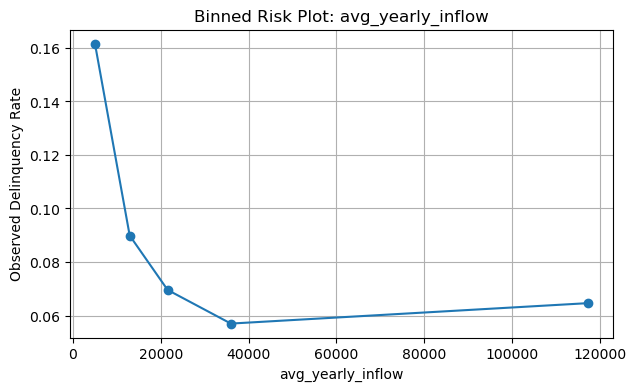

/tmp/ipykernel_278/4156484538.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


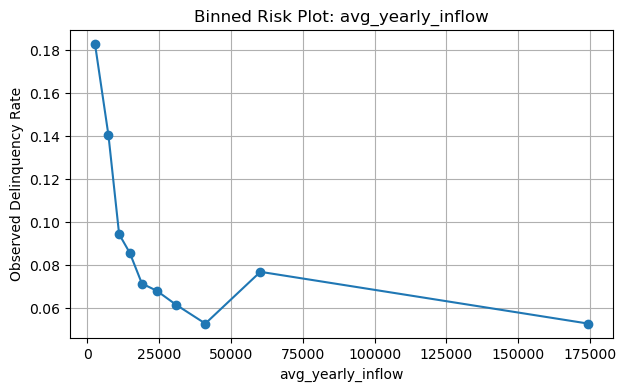

,bin,risk_rate,count,feature_mean
0,"(0.019, 5364.01]",0.182913,913,2677.868598
1,"(5364.01, 9310.322]",0.140197,913,7385.482892
2,"(9310.322, 12828.12]",0.094195,913,11094.390493
3,"(12828.12, 16834.254]",0.085526,912,14791.567588
4,"(16834.254, 21399.78]",0.071194,913,19026.129069
5,"(21399.78, 27151.348]",0.067908,913,24126.009869
6,"(27151.348, 34973.774]",0.061404,912,30841.038925
7,"(34973.774, 49173.874]",0.052574,913,41099.668576
8,"(49173.874, 77535.141]",0.076670,913,60247.724414
9,"(77535.141, 2307905.6]",0.052574,913,174306.313384


In [146]:
plot_binned_risk_5(df_eval, "avg_yearly_inflow")
plot_binned_risk_10(df_eval, "avg_yearly_inflow")

makes the most sense,  as average inflow increases, the deliquency rate decreases

/tmp/ipykernel_278/4156484538.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


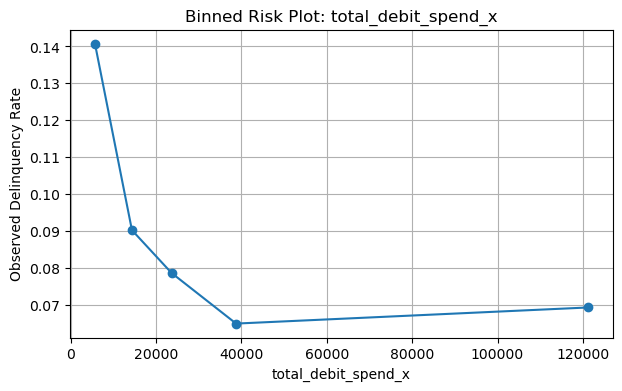

/tmp/ipykernel_278/4156484538.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


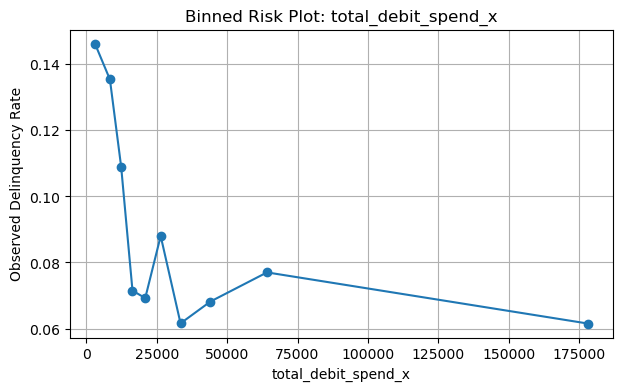

,bin,risk_rate,count,feature_mean
0,"(-0.001, 5922.268]",0.146154,910,3003.298385
1,"(5922.268, 10472.83]",0.135314,909,8326.084389
2,"(10472.83, 14226.716]",0.108911,909,12323.017921
3,"(14226.716, 18419.06]",0.071507,909,16346.116799
4,"(18419.06, 23282.89]",0.069231,910,20871.475220
5,"(23282.89, 29705.794]",0.088009,909,26363.162145
6,"(29705.794, 37609.454]",0.061606,909,33420.748680
7,"(37609.454, 51810.208]",0.068207,909,44058.018042
8,"(51810.208, 81204.458]",0.077008,909,64144.431188
9,"(81204.458, 2356517.89]",0.061538,910,178242.856560


In [147]:
plot_binned_risk_5(df_eval, "total_debit_spend_x")
plot_binned_risk_10(df_eval, "total_debit_spend_x")

the plot shows that people who spend very little tend to have higher delinquency risk, while people who spend more overall tend to have lower risk. this is likely because higher spending reflects greater income and financial capacity, whereas very low spending may indicate financial stress or limited resources

/tmp/ipykernel_278/4156484538.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


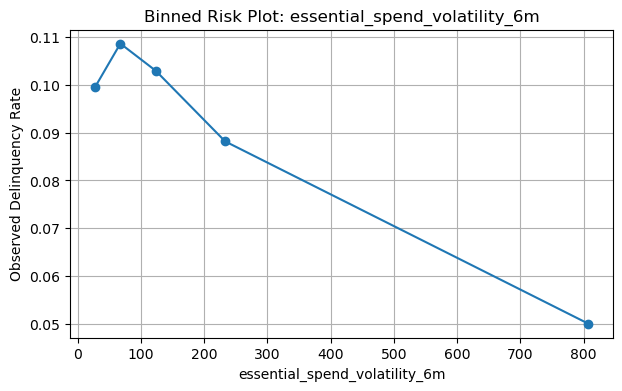

/tmp/ipykernel_278/4156484538.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


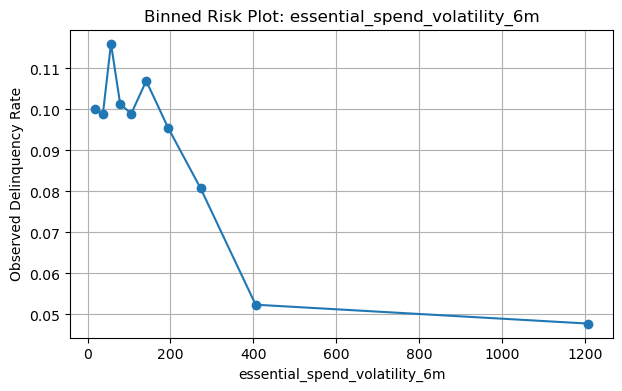

,bin,risk_rate,count,feature_mean
0,"(-0.001, 27.243]",0.100000,880,17.646182
1,"(27.243, 46.537]",0.098976,879,36.979687
2,"(46.537, 66.362]",0.116041,879,56.353090
3,"(66.362, 91.291]",0.101251,879,78.633581
4,"(91.291, 121.074]",0.098976,879,105.426522
5,"(121.074, 165.199]",0.106940,879,141.453702
6,"(165.199, 228.174]",0.095563,879,193.912431
7,"(228.174, 325.124]",0.080774,879,272.430309
8,"(325.124, 516.244]",0.052332,879,405.502881
9,"(516.244, 25802.404]",0.047727,880,1207.935827


In [148]:
plot_binned_risk_5(df_eval, "essential_spend_volatility_6m")
plot_binned_risk_10(df_eval, "essential_spend_volatility_6m")

this plot shows that delinquency risk does not increase with higher volatility in essential spending. instead, risk is highest for consumers with low to moderate volatility and decreases sharply for those with very high volatility. while this may seem counterintuitive, high volatility likely reflects financial flexibility and higher income, whereas low volatility may indicate constrained budgets with limited ability to absorb shocks

/tmp/ipykernel_278/4156484538.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


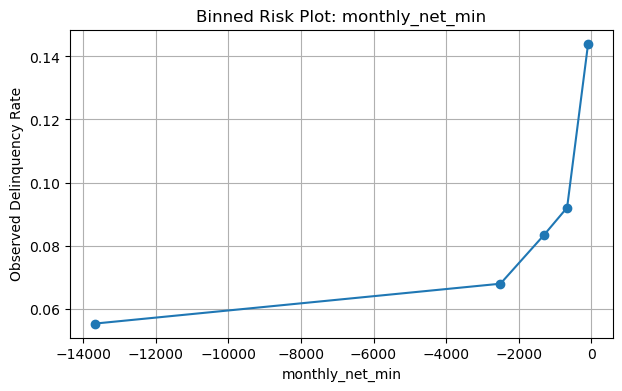

/tmp/ipykernel_278/4156484538.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


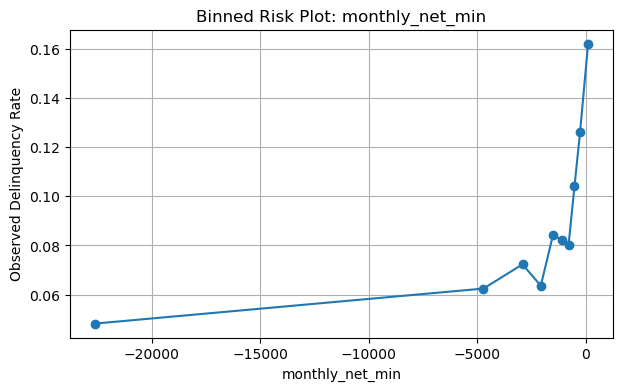

,bin,risk_rate,count,feature_mean
0,"(-695411.451, -6527.298]",0.048193,913,-22618.371260
1,"(-6527.298, -3517.386]",0.062432,913,-4725.822004
2,"(-3517.386, -2447.177]",0.072289,913,-2926.187601
3,"(-2447.177, -1763.704]",0.063596,912,-2084.678092
4,"(-1763.704, -1290.94]",0.084337,913,-1518.997919
5,"(-1290.94, -956.65]",0.082147,913,-1113.110164
6,"(-956.65, -667.507]",0.080044,912,-807.363443
7,"(-667.507, -403.114]",0.104053,913,-532.124228
8,"(-403.114, -151.22]",0.125958,913,-276.973779
9,"(-151.22, 5775.84]",0.162103,913,95.259737


In [149]:
plot_binned_risk_5(df_eval, "monthly_net_min")
plot_binned_risk_10(df_eval, "monthly_net_min")


- `monthly_net_min` is the one's worst month financially (money in - money out)
- at first glance, this plot seems backwards because wouldn't the people that have less money than they made in a month be more unlikely to pay back a loan
- after looking at this plot, we can think people with negative months probably have a higher overall income, can move money around, can have high losses bc they know they can recover; those with net zero live very close to their limit, have little or no financial buffer, are more vulnerable to falling behind

In [150]:
tmp = monthly_features[['prism_consumer_id', 'monthly_net_min', 'DQ_TARGET']].copy()

tmp['bin'] = pd.qcut(
    tmp['monthly_net_min'],
    q=10,
    duplicates='drop'
)
first_bin = tmp['bin'].cat.categories[0]
first_bin

Interval(-695411.451, -6324.205, closed='right')

In [151]:
first_bin_consumers = tmp[tmp['bin'] == first_bin]
first_bin_consumers


,prism_consumer_id,monthly_net_min,DQ_TARGET,bin
10,10008,-14908.59,1.0,"(-695411.451, -6324.205]"
39,10047,-7919.99,0.0,"(-695411.451, -6324.205]"
43,10050,-19029.62,0.0,"(-695411.451, -6324.205]"
44,10052,-34496.16,0.0,"(-695411.451, -6324.205]"
50,10060,-19160.66,0.0,"(-695411.451, -6324.205]"
...,...,...,...,...
12392,975,-17081.85,0.0,"(-695411.451, -6324.205]"
12445,98,-7453.06,0.0,"(-695411.451, -6324.205]"
12537,989,-24630.99,0.0,"(-695411.451, -6324.205]"
12547,99,-15943.42,0.0,"(-695411.451, -6324.205]"


In [152]:
cols_to_inspect = [
    "prism_consumer_id",
    "monthly_net_min",
    "monthly_net_avg",
    "monthly_net_max",
    "monthly_net_total",
    "avg_yearly_inflow",
    "std_inflow",
    "num_transactions",
    "DQ_TARGET"
]

available_cols = [c for c in cols_to_inspect if c in df_eval.columns]

inspect_df = (
    first_bin_consumers[["prism_consumer_id"]]   # keep just the ids from the bin
    .merge(df_eval[available_cols], on="prism_consumer_id", how="left")
)

inspect_df.head()



,prism_consumer_id,monthly_net_min,monthly_net_avg,monthly_net_max,monthly_net_total,avg_yearly_inflow,std_inflow,num_transactions,DQ_TARGET
0,10008,-14908.59,2775.926667,21669.59,24983.34,53823.99,8695.117572,6.0,1.0
1,10047,-7919.99,-897.843333,1110.11,-8080.59,34881.43,4431.989052,8.0,0.0
2,10050,-19029.62,-1993.446667,6720.42,-17941.02,149886.37,11544.575638,8.0,0.0
3,10052,-34496.16,-458.410000,53580.98,-4125.69,807478.11,144805.123461,8.0,0.0
4,10060,-19160.66,-1997.677778,1633.17,-17979.10,72830.00,3419.891336,8.0,0.0


In [153]:
inspect_df.sort_values("monthly_net_min").head(10)


,prism_consumer_id,monthly_net_min,monthly_net_avg,monthly_net_max,monthly_net_total,avg_yearly_inflow,std_inflow,num_transactions,DQ_TARGET
521,2267,-695411.45,-95221.250000,125106.56,-571327.50,632016.29,254192.006960,5.0,0.0
939,819,-564787.57,-2956.574286,554210.69,-20696.02,1611232.46,472353.930487,6.0,0.0
638,3183,-431251.87,-701.061429,445914.12,-4907.43,492235.54,178478.130846,6.0,0.0
81,10843,-295794.90,-1266.583333,566171.83,-11399.25,2307905.60,503525.172435,8.0,0.0
657,3343,-293943.91,1473.687143,300559.10,10315.81,407738.27,120712.928427,6.0,0.0
362,13344,-252980.77,10556.385556,330660.82,95007.47,403605.88,115835.669846,8.0,0.0
535,2403,-247778.59,-35805.830000,6018.30,-250640.81,409624.48,94733.407970,6.0,0.0
789,5523,-234826.66,-29545.430000,109204.89,-118181.72,1202281.45,61497.459864,3.0,0.0
626,3080,-219685.29,-46559.397500,-3988.82,-372475.18,98326.20,20411.018437,6.0,0.0
496,2003,-206932.32,-5023.440000,166599.89,-30140.64,215790.58,69681.638028,5.0,0.0


In [154]:
trxndf[
    (trxndf['prism_consumer_id'] == '2267') &
    (trxndf['credit_or_debit'] == 'DEBIT')
].sort_values(['amount'], ascending = False)

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
1190704,2267,1189690,EXTERNAL_TRANSFER,700005.00,DEBIT,2021-06-17
1190726,2267,1189712,EXTERNAL_TRANSFER,422583.60,DEBIT,2021-08-31
1190719,2267,1189705,EXTERNAL_TRANSFER,20005.00,DEBIT,2021-08-12
1190761,2267,1189747,CREDIT_CARD_PAYMENT,7500.00,DEBIT,2021-10-15
1190758,2267,1189744,SELF_TRANSFER,4000.00,DEBIT,2021-10-02
...,...,...,...,...,...,...
1190756,2267,1189742,MISCELLANEOUS,13.00,DEBIT,2021-09-17
1190718,2267,1189704,EXTERNAL_TRANSFER,7.71,DEBIT,2021-06-21
1190733,2267,1189719,GROCERIES,2.59,DEBIT,2021-07-16
1190705,2267,1189691,INVESTMENT,0.84,DEBIT,2021-06-17


???!?!??

/tmp/ipykernel_278/4156484538.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


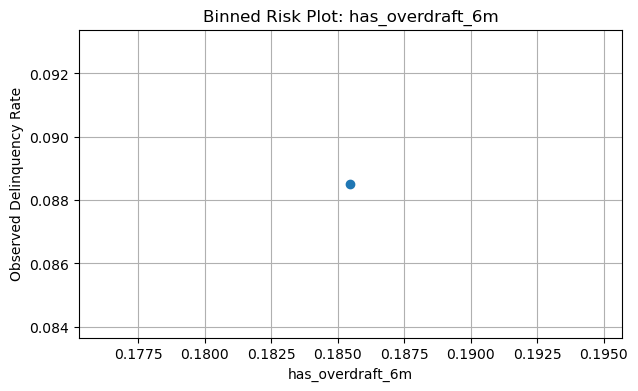

/tmp/ipykernel_278/4156484538.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


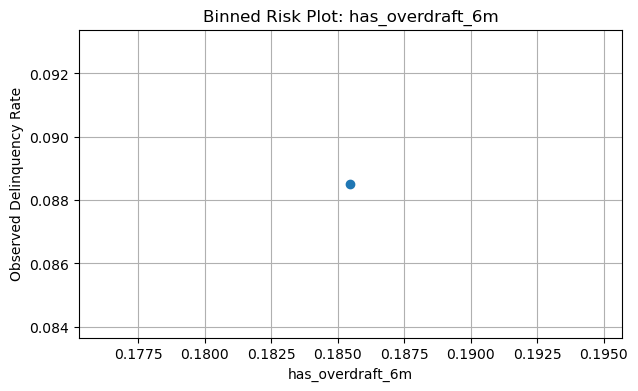

,bin,risk_rate,count,feature_mean
0,"(-0.001, 1.0]",0.088519,9128,0.185473


In [155]:
plot_binned_risk_5(df_eval, "has_overdraft_6m")
plot_binned_risk_10(df_eval, "has_overdraft_6m")



this feature is binary so this plot actually doesn't make sense 

In [156]:
df_eval.groupby("has_overdraft_6m")["DQ_TARGET"].agg(
    risk_rate="mean",
    count="size"
)


,risk_rate,count
has_overdraft_6m,,
0,0.073436,7435
1,0.154755,1693


consumers who had overdraft in the last 6 months are more than twice as likely to become delinquent compared to those who did not overdraft

## Models

In [174]:
def eval_model(name, model, Xtr, ytr, Xte, yte):
    t0 = time.perf_counter()
    model.fit(Xtr, ytr)
    t1 = time.perf_counter()

    t2 = time.perf_counter()
    y_prob = model.predict_proba(Xte)[:, 1]
    t3 = time.perf_counter()

    auc = roc_auc_score(yte, y_prob)
    print(f"{name}")
    print(f"  train_time: {t1-t0:.4f}s | score_time: {t3-t2:.4f}s | AUC: {auc:.4f}")
    return {
        "model": name,
        "train_time": t1 - t0,
        "score_time": t3 - t2,
        "auc": auc
    }


In [175]:
# logistic regression
logreg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=10000, solver="lbfgs"))
])


In [251]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    # class_weight="balanced",
    n_jobs=-1,
    random_state=42
)


In [208]:
xgb_1 = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric="auc",
    tree_method="hist",
    random_state=42
)


In [242]:
# changing parameters 
xgb_2 = XGBClassifier(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    verbosity=0
)

In [422]:
xgb_3 = XGBClassifier(
    n_estimators=600,
    max_depth=3,
    learning_rate=0.03,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=8,
    gamma=1,
    reg_alpha=1,
    reg_lambda=10,
    eval_metric="auc",
    tree_method="hist",
    random_state=42
)


In [423]:
lgbm = LGBMClassifier(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_samples=20,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    verbose=-1 
)

In [424]:
cat = CatBoostClassifier(
    iterations=600,
    depth=6,
    learning_rate=0.03,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=0   # important to silence training output
)


In [426]:
results = []

results.append(eval_model(
    "LogReg (scaled, top 50 features)",
    logreg,
    X_train_50_mi, y_train,
    X_test_50_mi, y_test
))

results.append(eval_model(
    "Random Forest (top 50 features)",
    rf,
    X_train_50_mi, y_train,
    X_test_50_mi, y_test
))

results.append(eval_model(
    "XGBoost (top 50 features)",
    xgb_1,
    X_train_50_mi, y_train,
    X_test_50_mi, y_test
))

results.append(eval_model(
    "XGBoost - heidi's parameters (top 50)",
    xgb_2,
    X_train_50_mi, y_train,
    X_test_50_mi, y_test
))

results.append(eval_model(
    "XGBoost - tuned hyperparameters (top 50)",
    xgb_3,
    X_train_50_mi, y_train, X_test_50_mi, y_test
))

results.append(eval_model(
    "LightGBM (top 50)",
    lgbm,
    X_train_50_mi, y_train,
    X_test_50_mi, y_test
))

results.append(eval_model(
    "CatBoost (top 50)",
    cat,
    X_train_50_mi, y_train,
    X_test_50_mi, y_test
))




LogReg (scaled, top 50 features)
  train_time: 0.1472s | score_time: 0.0040s | AUC: 0.7553
Random Forest (top 50 features)
  train_time: 1.9042s | score_time: 0.0886s | AUC: 0.8043
XGBoost (top 50 features)
  train_time: 0.6786s | score_time: 0.0067s | AUC: 0.8107
XGBoost - heidi's parameters (top 50)
  train_time: 1.6424s | score_time: 0.0120s | AUC: 0.8027
XGBoost - tuned hyperparameters (top 50)
  train_time: 0.7233s | score_time: 0.0073s | AUC: 0.8109
LightGBM (top 50)
  train_time: 1.0368s | score_time: 0.0172s | AUC: 0.8005
CatBoost (top 50)
  train_time: 2.5697s | score_time: 0.0049s | AUC: 0.8072


In [434]:
import numpy as np

# Separate classes
X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]

# Oversample minority class
n_majority = len(X_train_0)
X_train_1_oversampled = X_train_1.sample(n=n_majority, replace=True, random_state=42)
y_train_1_oversampled = y_train_1.sample(n=n_majority, replace=True, random_state=42)

# Combine back
X_train_bal = np.vstack([X_train_0, X_train_1_oversampled])
y_train_bal = np.concatenate([y_train_0, y_train_1_oversampled])


In [439]:
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(256,128,64),
        activation="relu",
        max_iter=100,
        early_stopping=True,
        random_state=42,
        alpha=1e-2
    ))
])

pipe.fit(X_train_bal, y_train_bal)

y_prob = pipe.predict_proba(X_test)[:, 1]
print("MLP ROC-AUC:", roc_auc_score(y_test, y_prob))

MLP ROC-AUC: 0.7135488205681529


## dealing with class imbalance

In [241]:
consdf['DQ_TARGET'].value_counts()

DQ_TARGET
0.0    10994
1.0     1006
Name: count, dtype: int64

In [245]:
# first we are trying with just adding class_weight to logreg
logreg_bal = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # handles NaNs
    ("model", LogisticRegression(
        class_weight="balanced",
        solver="liblinear",
        max_iter=2000,
        random_state=42
    ))
])

results.append(eval_model(
    "LogReg (balanced + median impute)",
    logreg_bal,
    X_train_50, y_train, X_test_50, y_test
))

LogReg (balanced + median impute)
  train_time: 2.0142s | score_time: 0.0040s | AUC: 0.7153


### oversampling

In [249]:
# Logistic Regression + ROS
logreg_ros = ImbPipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("sampler", RandomOverSampler(random_state=42)),
    ("model", LogisticRegression(max_iter=10000, solver="lbfgs"))
])

results.append(eval_model(
    "LogReg + RandomOverSampler",
    logreg_ros,
    X_train_50, y_train, X_test_50, y_test
))

LogReg + RandomOverSampler
  train_time: 1.8828s | score_time: 0.0057s | AUC: 0.7481


In [253]:
rf_ros = ImbPipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("sampler", RandomOverSampler(random_state=42)),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight=None,   # IMPORTANT: don't double-correct if oversampling
        n_jobs=-1,
        random_state=42
    ))
])
results.append(eval_model(
    "RF + RandomOverSampler",
    rf_ros,
    X_train_50, y_train, X_test_50, y_test
))

RF + RandomOverSampler
  train_time: 2.5363s | score_time: 0.0937s | AUC: 0.7879


In [254]:
xgb_ros = ImbPipeline([
    ("imputer", SimpleImputer(strategy="median")),  # optional for xgb, fine to keep consistent
    ("sampler", RandomOverSampler(random_state=42)),
    ("model", XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.03,
        subsample=0.85,
        colsample_bytree=0.85,
        min_child_weight=3,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1.0,
        eval_metric="auc",
        tree_method="hist",
        random_state=42
        # IMPORTANT: no scale_pos_weight when oversampling
    ))
])

results.append(eval_model(
    "XGBoost + RandomOverSampler",
    xgb_ros,
    X_train_50, y_train, X_test_50, y_test
))

XGBoost + RandomOverSampler
  train_time: 0.8208s | score_time: 0.0065s | AUC: 0.7889


### SMOTE

In [416]:
# Logistic Regression + SMOTE
logreg_smote = ImbPipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("sampler", SMOTE(random_state=42, k_neighbors=5)),
    ("model", LogisticRegression(max_iter=10000, solver="lbfgs"))
])

results.append(eval_model(
    "LogReg + SMOTE",
    logreg_smote,
    X_train_50_mi, y_train,
    X_test_50_mi, y_test
))


LogReg + SMOTE
  train_time: 1.0956s | score_time: 0.0852s | AUC: 0.7454


In [417]:
# Random Forest + SMOTE
rf_smote = ImbPipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("sampler", SMOTE(random_state=42, k_neighbors=5)),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight=None,   # don't double-correct
        n_jobs=-1,
        random_state=42
    ))
])

results.append(eval_model(
    "RF + SMOTE",
    rf_smote,
    X_train_50_mi, y_train,
    X_test_50_mi, y_test
))


RF + SMOTE
  train_time: 3.3559s | score_time: 0.1160s | AUC: 0.8034


In [421]:
# XGBoost + SMOTE
xgb_smote = ImbPipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("sampler", SMOTE(random_state=42, k_neighbors=3)),
    ("model", XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.03,
        subsample=0.85,
        colsample_bytree=0.85,
        min_child_weight=3,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1.0,
        eval_metric="auc",
        tree_method="hist",
        random_state=42
    ))
])

results.append(eval_model(
    "XGBoost + SMOTE",
    xgb_smote,
    X_train_50_mi, y_train,
    X_test_50_mi, y_test
))

XGBoost + SMOTE
  train_time: 0.9566s | score_time: 0.0057s | AUC: 0.7914


In [420]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier

pipe = ImbPipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("sampler", SMOTE(random_state=42)),
    ("model", XGBClassifier(
        eval_metric="auc",
        tree_method="hist",
        random_state=42,
        n_jobs=-1
    ))
])

param_dist = {
    "sampler__k_neighbors": [3, 5, 7],

    "model__n_estimators": [300, 600, 900],
    "model__max_depth": [2, 3, 4, 5],
    "model__learning_rate": [0.01, 0.03, 0.05],
    "model__subsample": [0.6, 0.7, 0.85],
    "model__colsample_bytree": [0.6, 0.7, 0.85],
    "model__min_child_weight": [3, 5, 8, 12],
    "model__gamma": [0, 0.5, 1, 2],
    "model__reg_alpha": [0, 0.1, 0.5, 1.0],
    "model__reg_lambda": [1, 5, 10, 20],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=25,
    scoring="roc_auc",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train_50_mi, y_train)

print("Best CV AUC:", search.best_score_)
print("Best params:\n", search.best_params_)

best_smote_xgb = search.best_estimator_

# Evaluate on held-out test
from sklearn.metrics import roc_auc_score
y_test_prob = best_smote_xgb.predict_proba(X_test_50_mi)[:, 1]
print("Test AUC:", roc_auc_score(y_test, y_test_prob))


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best CV AUC: 0.7748278675474524
Best params:
 {'sampler__k_neighbors': 3, 'model__subsample': 0.7, 'model__reg_lambda': 1, 'model__reg_alpha': 0.1, 'model__n_estimators': 300, 'model__min_child_weight': 5, 'model__max_depth': 3, 'model__learning_rate': 0.05, 'model__gamma': 0, 'model__colsample_bytree': 0.6}
Test AUC: 0.7799924323361824


In [428]:
import numpy as np
import pandas as pd

def smote_audit(X, low_card_max=10, sparse_zero_thresh=0.95, show=30):
    X0 = X.copy()

    # numeric coercion check
    non_numeric = X0.columns[~X0.apply(lambda s: pd.api.types.is_numeric_dtype(s))]
    
    # cardinality per column (ignore NaN)
    nunique = X0.nunique(dropna=True)

    # binary-ish (values subset of {0,1})
    def is_binary(col):
        vals = pd.Series(col).dropna().unique()
        return len(vals) <= 2 and set(vals).issubset({0, 1})

    binary_cols = [c for c in X0.columns if is_binary(X0[c])]

    # low-cardinality numeric (e.g., 0/1/2/3, buckets, counts)
    low_card_cols = nunique[nunique <= low_card_max].index.tolist()

    # sparsity: fraction of zeros (treat NaN as not-zero for this measure)
    zero_frac = (X0 == 0).mean(numeric_only=False)
    # if non-numeric exists, (X==0) may be False everywhere; handle that:
    zero_frac = zero_frac.reindex(X0.columns).fillna(0)

    sparse_cols = zero_frac[zero_frac >= sparse_zero_thresh].sort_values(ascending=False).index.tolist()

    print(f"Total features: {X0.shape[1]}")
    print(f"Non-numeric features: {len(non_numeric)}")
    if len(non_numeric) > 0:
        print("  Examples:", list(non_numeric[:min(10, len(non_numeric))]))

    print(f"\nBinary features (subset of {{0,1}}): {len(binary_cols)}")
    print("  Examples:", binary_cols[:min(show, len(binary_cols))])

    print(f"\nLow-cardinality (<= {low_card_max} unique values): {len(low_card_cols)}")
    print("  Top low-cardinality examples:", low_card_cols[:min(show, len(low_card_cols))])

    print(f"\nVery sparse features (>= {sparse_zero_thresh:.0%} zeros): {len(sparse_cols)}")
    print("  Most sparse examples:")
    for c in sparse_cols[:min(show, len(sparse_cols))]:
        print(f"   - {c}: zero_frac={zero_frac[c]:.3f}, nunique={nunique[c]}")

    # overlap counts
    overlap_bin_sparse = len(set(binary_cols).intersection(set(sparse_cols)))
    overlap_low_sparse = len(set(low_card_cols).intersection(set(sparse_cols)))
    print(f"\nOverlap: binary ∩ sparse = {overlap_bin_sparse}, low-card ∩ sparse = {overlap_low_sparse}")

    # return useful tables
    summary = pd.DataFrame({
        "nunique": nunique,
        "zero_frac": zero_frac,
        "is_binary": [c in binary_cols for c in X0.columns],
        "is_low_card": [c in low_card_cols for c in X0.columns],
        "is_sparse": [c in sparse_cols for c in X0.columns],
    }).sort_values(["is_sparse", "is_binary", "nunique", "zero_frac"], ascending=[False, False, True, False])

    return summary, binary_cols, low_card_cols, sparse_cols, non_numeric

summary, binary_cols, low_card_cols, sparse_cols, non_numeric = smote_audit(X_train_50_mi)
summary.head(20)


Total features: 50
Non-numeric features: 0

Binary features (subset of {0,1}): 5
  Examples: ['has_overdraft_6m', 'has_acct_fee_6m', 'pets_6m', 'discretionary_drop_flag_3m', 'bnpl_usage_flag']

Low-cardinality (<= 10 unique values): 6
  Top low-cardinality examples: ['num_transactions', 'has_overdraft_6m', 'has_acct_fee_6m', 'pets_6m', 'discretionary_drop_flag_3m', 'bnpl_usage_flag']

Very sparse features (>= 95% zeros): 0
  Most sparse examples:

Overlap: binary ∩ sparse = 0, low-card ∩ sparse = 0


,nunique,zero_frac,is_binary,is_low_card,is_sparse
has_overdraft_6m,2,0.815119,True,True,False
pets_6m,2,0.757875,True,True,False
discretionary_drop_flag_3m,2,0.746234,True,True,False
bnpl_usage_flag,2,0.711038,True,True,False
has_acct_fee_6m,2,0.548617,True,True,False
num_transactions,10,0.000000,False,True,False
month_count,12,0.000000,False,False,False
atm_cash_freq_6m,79,0.548617,False,False,False
OVERDRAFT_trxnavg,213,0.807039,False,False,False
income_span_days,259,0.027527,False,False,False


In [429]:
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Impute first because SMOTE can't handle NaNs
imp = SimpleImputer(strategy="median")
X_imp = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns, index=X_train.index)

sm = SMOTE(random_state=42, k_neighbors=3)
X_sm, y_sm = sm.fit_resample(X_imp, y_train)

X_sm = pd.DataFrame(X_sm, columns=X_train.columns)

# Find columns that were binary in original but became fractional after SMOTE
fractional_in_binary = []
for c in binary_cols:
    vals = pd.Series(X_sm[c].unique())
    # allow tiny float error
    non01 = vals[~vals.round(6).isin([0.0, 1.0])]
    if len(non01) > 0:
        fractional_in_binary.append((c, len(non01), non01.head(5).tolist()))

print("Binary columns that became non-binary after SMOTE:", len(fractional_in_binary))
for c, k, ex in fractional_in_binary[:20]:
    print(f" - {c}: {k} non-binary values, examples={ex}")


Binary columns that became non-binary after SMOTE: 5
 - has_overdraft_6m: 2496 non-binary values, examples=[0.7425308328404214, 0.07663580647524881, 0.8093243982852624, 0.2136422669385185, 0.27149875418186786]
 - has_acct_fee_6m: 2705 non-binary values, examples=[0.25746916715957857, 0.2160601162447664, 0.2136422669385185, 0.27149875418186786, 0.76821640971065]
 - pets_6m: 1732 non-binary values, examples=[0.8093243982852624, 0.7863577330614815, 0.632216597753949, 0.27149875418186786, 0.3186089627636072]
 - discretionary_drop_flag_3m: 592 non-binary values, examples=[0.23178359028935003, 0.5854839351832077, 0.5408107662674382, 0.34522995366997244, 0.7324138648126686]
 - bnpl_usage_flag: 2629 non-binary values, examples=[0.25746916715957857, 0.8281168290063428, 0.7839398837552336, 0.367783402246051, 0.3186089627636072]


this is a problem because SMOTE doesn't work well with binary features; turning them into 0.74 overdrafts 
generating impossible values and unrealistic borrowers


In [430]:
# Identify columns that look like counts/integers (all whole numbers in the original train after impute)
int_like_cols = []
for c in X_imp.columns:
    s = X_imp[c]
    if pd.api.types.is_numeric_dtype(s):
        # treat as int-like if values are close to integers
        if np.all(np.isclose(s, np.round(s), atol=1e-8)):
            int_like_cols.append(c)

# After SMOTE, see which became fractional
fractional_int_like = []
for c in int_like_cols:
    s = X_sm[c]
    if not np.all(np.isclose(s, np.round(s), atol=1e-8)):
        # measure fraction of rows that are non-integers
        frac_nonint = np.mean(~np.isclose(s, np.round(s), atol=1e-8))
        if frac_nonint > 0:
            fractional_int_like.append((c, frac_nonint))

fractional_int_like = sorted(fractional_int_like, key=lambda x: x[1], reverse=True)

print("Integer-like columns that became fractional after SMOTE:", len(fractional_int_like))
for c, frac_nonint in fractional_int_like[:25]:
    print(f" - {c}: {frac_nonint:.2%} non-integer values")


Integer-like columns that became fractional after SMOTE: 12
 - trxndf_count: 44.53% non-integer values
 - income_span_days: 42.07% non-integer values
 - atm_cash_freq_6m: 36.56% non-integer values
 - debt_category_count: 31.88% non-integer values
 - num_transactions: 22.92% non-integer values
 - month_count: 22.11% non-integer values
 - has_acct_fee_6m: 20.32% non-integer values
 - bnpl_usage_flag: 19.75% non-integer values
 - child_dependents_6m: 19.75% non-integer values
 - has_overdraft_6m: 18.75% non-integer values
 - pets_6m: 13.01% non-integer values
 - discretionary_drop_flag_3m: 4.45% non-integer values
